# Diagnosing Biased Inference with Divergences

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from collections import defaultdict

print('Runing on PyMC3 v{}'.format(pm.__version__))

Runing on PyMC3 v3.9.1


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
SEED = [20100420, 20134234]

This notebook is a PyMC3 port of [Michael Betancourt's post on ms-stan](http://mc-stan.org/documentation/case-studies/divergences_and_bias.html). For detailed explanation of the underlying mechanism please check [the original post](http://mc-stan.org/documentation/case-studies/divergences_and_bias.html) and Betancourt's [excellent paper](https://arxiv.org/abs/1701.02434).

Bayesian statistics is all about building a model and estimating the parameters in that model. However, a naive or direct parameterization of our probability model can sometimes be ineffective, you can check out [Thomas Wiecki's blog post](http://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/) on the same issue in PyMC3. Suboptimal parameterization often leads to slow sampling, and more problematic, biased MCMC estimators. 

More formally, as explained in [the original post](http://mc-stan.org/documentation/case-studies/divergences_and_bias.html):

Markov chain Monte Carlo (MCMC) approximates expectations with respect to a given target distribution, 

$$ \mathbb{E}{\pi} [ f ] = \int \mathrm{d}q \, \pi (q) \, f(q)$$ 

using the states of a Markov chain, ${q{0}, \ldots, q_{N} }$, 

$$ \mathbb{E}{\pi} [ f ] \approx \hat{f}{N} = \frac{1}{N + 1} \sum_{n = 0}^{N} f(q_{n}) $$  

These estimators, however, are guaranteed to be accurate only asymptotically as the chain grows to be infinitely long, 

$$ \lim_{N \rightarrow \infty} \hat{f}{N} = \mathbb{E}{\pi} [ f ]$$  

To be useful in applied analyses, we need MCMC estimators to converge to the true expectation values sufficiently quickly that they are reasonably accurate before we exhaust our finite computational resources. This fast convergence requires strong ergodicity conditions to hold, in particular geometric ergodicity between a Markov transition and a target distribution. Geometric ergodicity is usually the necessary condition for MCMC estimators to follow a central limit theorem, which ensures not only that they are unbiased even after only a finite number of iterations but also that we can empirically quantify their precision using the MCMC standard error.

Unfortunately, proving geometric ergodicity is infeasible for any nontrivial problem. Instead we must rely on empirical diagnostics that identify obstructions to geometric ergodicity, and hence well-behaved MCMC estimators. For a general Markov transition and target distribution, the best known diagnostic is the split $\hat{R}$ statistic over an ensemble of Markov chains initialized from diffuse points in parameter space; to do any better we need to exploit the particular structure of a given transition or target distribution.
 
Hamiltonian Monte Carlo, for example, is especially powerful in this regard as its failures to be geometrically ergodic with respect to any target distribution manifest in distinct behaviors that have been developed into sensitive diagnostics. One of these behaviors is the appearance of divergences that indicate the Hamiltonian Markov chain has encountered regions of high curvature in the target distribution which it cannot adequately explore.

In this notebook we aim to identify divergences and the underlying pathologies in `PyMC3`.

## The Eight Schools Model

The hierarchical model of the Eight Schools dataset (Rubin 1981) as seen in `Stan`:

$$\mu \sim \mathcal{N}(0, 5)$$
$$\tau \sim \text{Half-Cauchy}(0, 5)$$
$$\theta_{n} \sim \mathcal{N}(\mu, \tau)$$
$$y_{n} \sim \mathcal{N}(\theta_{n}, \sigma_{n}),$$  

where $n \in \{1, \ldots, 8 \}$ and the $\{ y_{n}, \sigma_{n} \}$ are given as data.  

Inferring the hierarchical hyperparameters, $\mu$ and $\sigma$, together with the group-level parameters, $\theta_{1}, \ldots, \theta_{8}$, allows the model to pool data across the groups and reduce their posterior variance. Unfortunately, the direct *centered* parameterization also squeezes the posterior distribution into a particularly challenging geometry that obstructs geometric ergodicity and hence biases MCMC estimation.

In [3]:
# Data of the Eight Schools Model
J = 8
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
# tau = 25.

## A Centered Eight Schools Implementation  

`Stan` model:

```C
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta[J];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
}
```
Similarly, we can easily implement it in `PyMC3`

In [4]:
with pm.Model() as Centered_eight:
    mu = pm.Normal('mu', mu=0, sigma=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta = pm.Normal('theta', mu=mu, sigma=tau, shape=J)
    obs = pm.Normal('obs', mu=theta, sigma=sigma, observed=y)

Unfortunately, this direct implementation of the model exhibits a pathological geometry that frustrates geometric ergodicity. Even more worrisome, the resulting bias is subtle and may not be obvious upon inspection of the Markov chain alone. To understand this bias, let's consider first a short Markov chain, commonly used when computational expediency is a motivating factor, and only afterwards a longer Markov chain.

### A Dangerously-Short Markov Chain

In [5]:
with Centered_eight:
    short_trace = pm.sample(600, chains=2, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 2 chains for 1_000 tune and 600 draw iterations (2_000 + 1_200 draws total) took 17 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4129320535021329, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In the [original post](http://mc-stan.org/documentation/case-studies/divergences_and_bias.html) a single chain of 1200 sample is applied. However, since split $\hat{R}$[[1]](#fn1) is not implemented in `PyMC3` we fit 2 chains with 600 sample each instead.  

The Gelman-Rubin diagnostic $\hat{R}$ doesn’t indicate any problem (values are all close to 1). You could try re-running the model with a different seed and see if this still holds.

<span id="fn1">[1] "Split $\hat{R}$" is $\hat{R}$ computed with the first half of a trace against the second.</span>

In [6]:
with Centered_eight:
    short_trace_summary = pm.summary(short_trace).round(2)
short_trace_summary

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu        3.79  2.98   -2.84     9.07       0.19     0.14     242.0   228.0   
theta[0]  5.61  5.86   -4.26    16.79       0.37     0.44     247.0    90.0   
theta[1]  4.14  4.43   -4.27    13.06       0.24     0.42     327.0    56.0   
theta[2]  3.21  5.04   -6.39    13.57       0.26     0.24     371.0   219.0   
theta[3]  3.93  4.65   -5.52    12.76       0.22     0.20     451.0   275.0   
theta[4]  3.14  4.21   -5.88    10.77       0.20     0.20     422.0   226.0   
theta[5]  3.13  4.74   -7.03    11.94       0.23     0.37     424.0    81.0   
theta[6]  5.81  5.05   -2.35    16.51       0.92     0.72      30.0    26.0   
theta[7]  4.08  4.73   -4.63    14.50       0.22     0.43     481.0    60.0   
tau       3.67  3.10    0.62     9.55       1.26     0.94       6.0     6.0   

          ess_bulk  ess_tail  r_hat  
mu           221.0     402.0   1.27  
theta[0]     220.0     198.0   1.32  
theta[1]     293.0     506.0   1.42  
theta[2]     284.0     371.0   1.16  
theta[3]     345.0     499.0   1.19  
theta[4]     362.0     380.0   1.23  
theta[5]     378.0     368.0   1.40  
theta[6]      79.0     313.0   1.25  
theta[7]     433.0     580.0   1.47  
tau            3.0       6.0   1.61

Moreover, the trace plots all look fine. Let's consider, for example, the hierarchical standard deviation $\tau$, or more specifically, its logarithm, $log(\tau)$. Because $\tau$ is constrained to be positive, its logarithm will allow us to better resolve behavior for small values. Indeed the chains seem to be exploring both small and large values reasonably well,



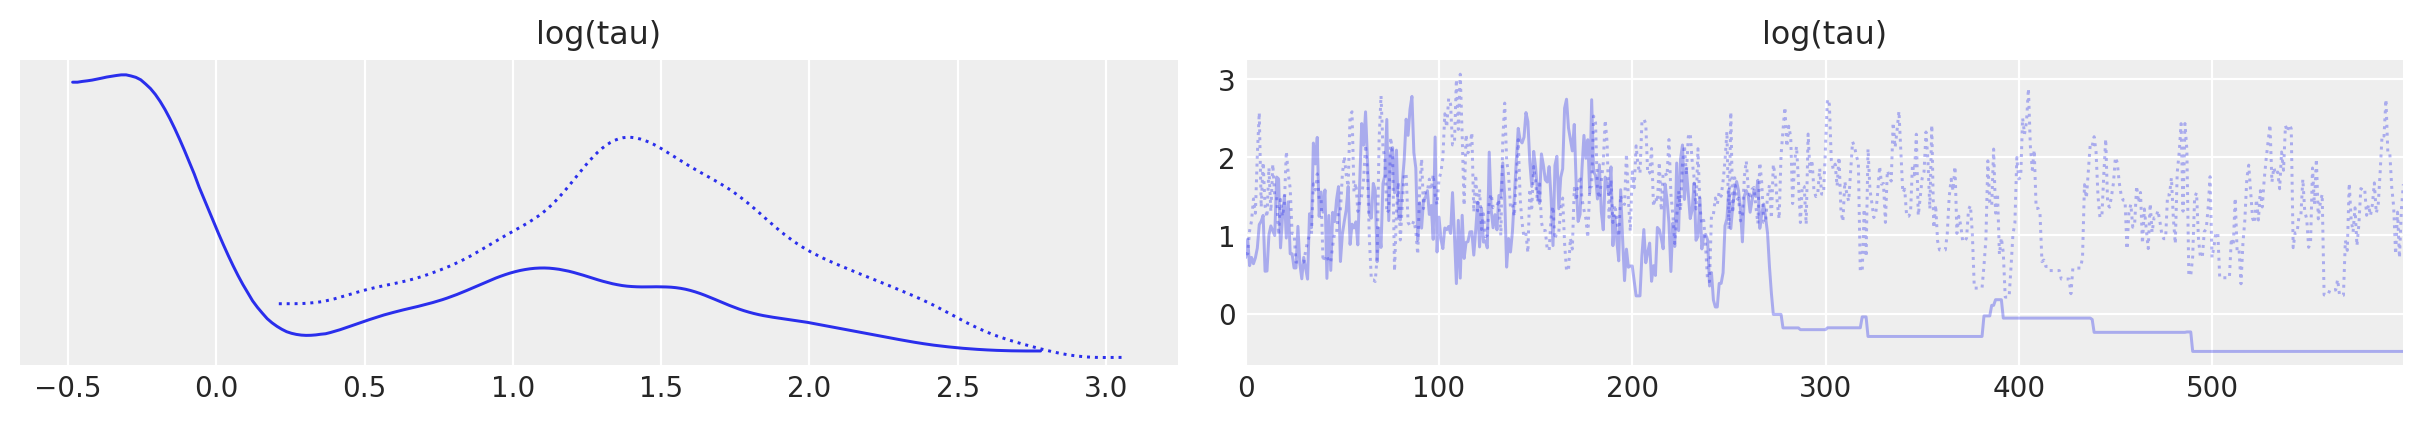

In [7]:
# plot the trace of log(tau)
with Centered_eight:
    pm.traceplot({"log(tau)": short_trace.get_values(varname='tau_log__', combine=False)});

Unfortunately, the resulting estimate for the mean of $log(\tau)$ is strongly biased away from the true value, here shown in grey.  (Note that when we address a multi-chain trace, it is done as if "flattened" by concatenating the chains in chain order.)

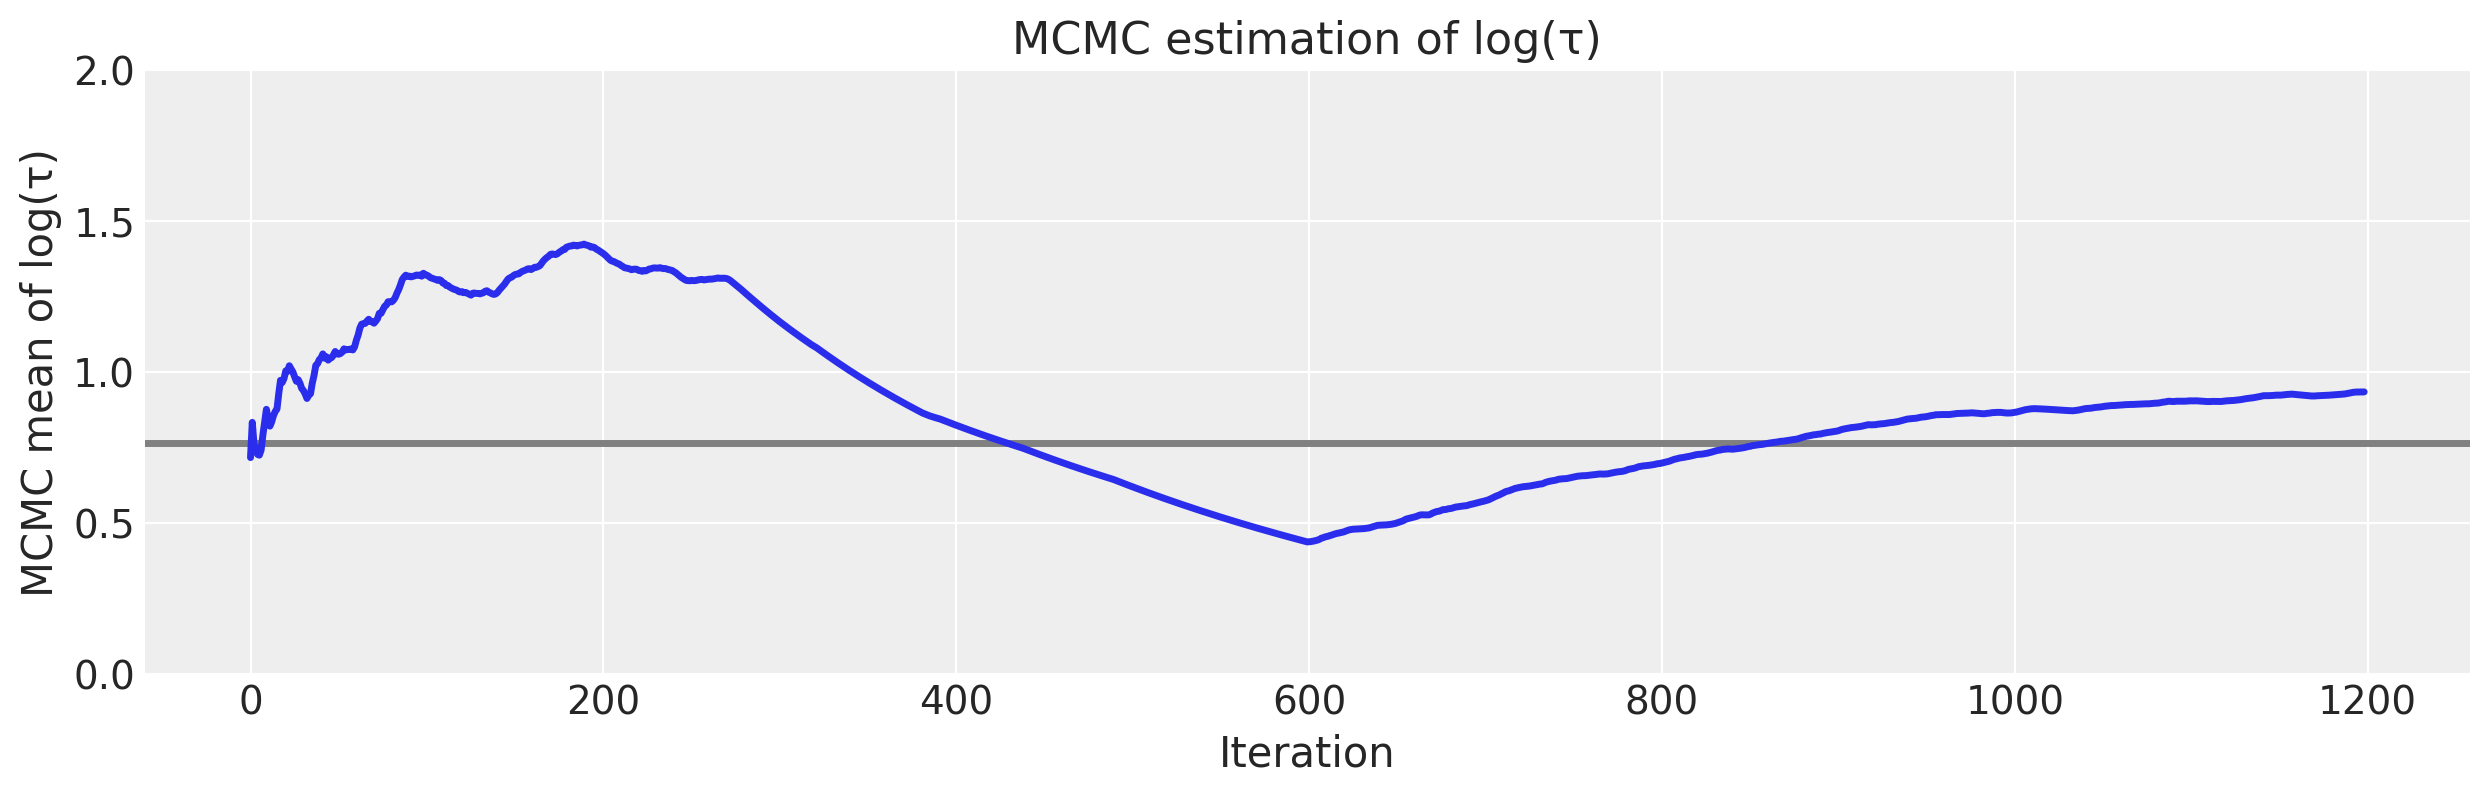

In [8]:
# plot the estimate for the mean of log(τ) cumulating mean
logtau = np.log(short_trace['tau'])
mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
plt.plot(mlogtau, lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(τ)')
plt.title('MCMC estimation of log(τ)');

Hamiltonian Monte Carlo, however, is not so oblivious to these issues as $\approx$ 3% of the iterations in our lone Markov chain ended with a divergence.

In [9]:
# display the total number and percentage of divergent
divergent = short_trace['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(short_trace) * 100
print('Percentage of Divergent %.1f' % divperc)

Number of Divergent 56
Percentage of Divergent 9.3


Even with a single short chain these divergences are able to identity the bias and advise skepticism of any resulting MCMC estimators.

Additionally, because the divergent transitions, here shown in green, tend to be located near the pathologies we can use them to identify the location of the problematic neighborhoods in parameter space.

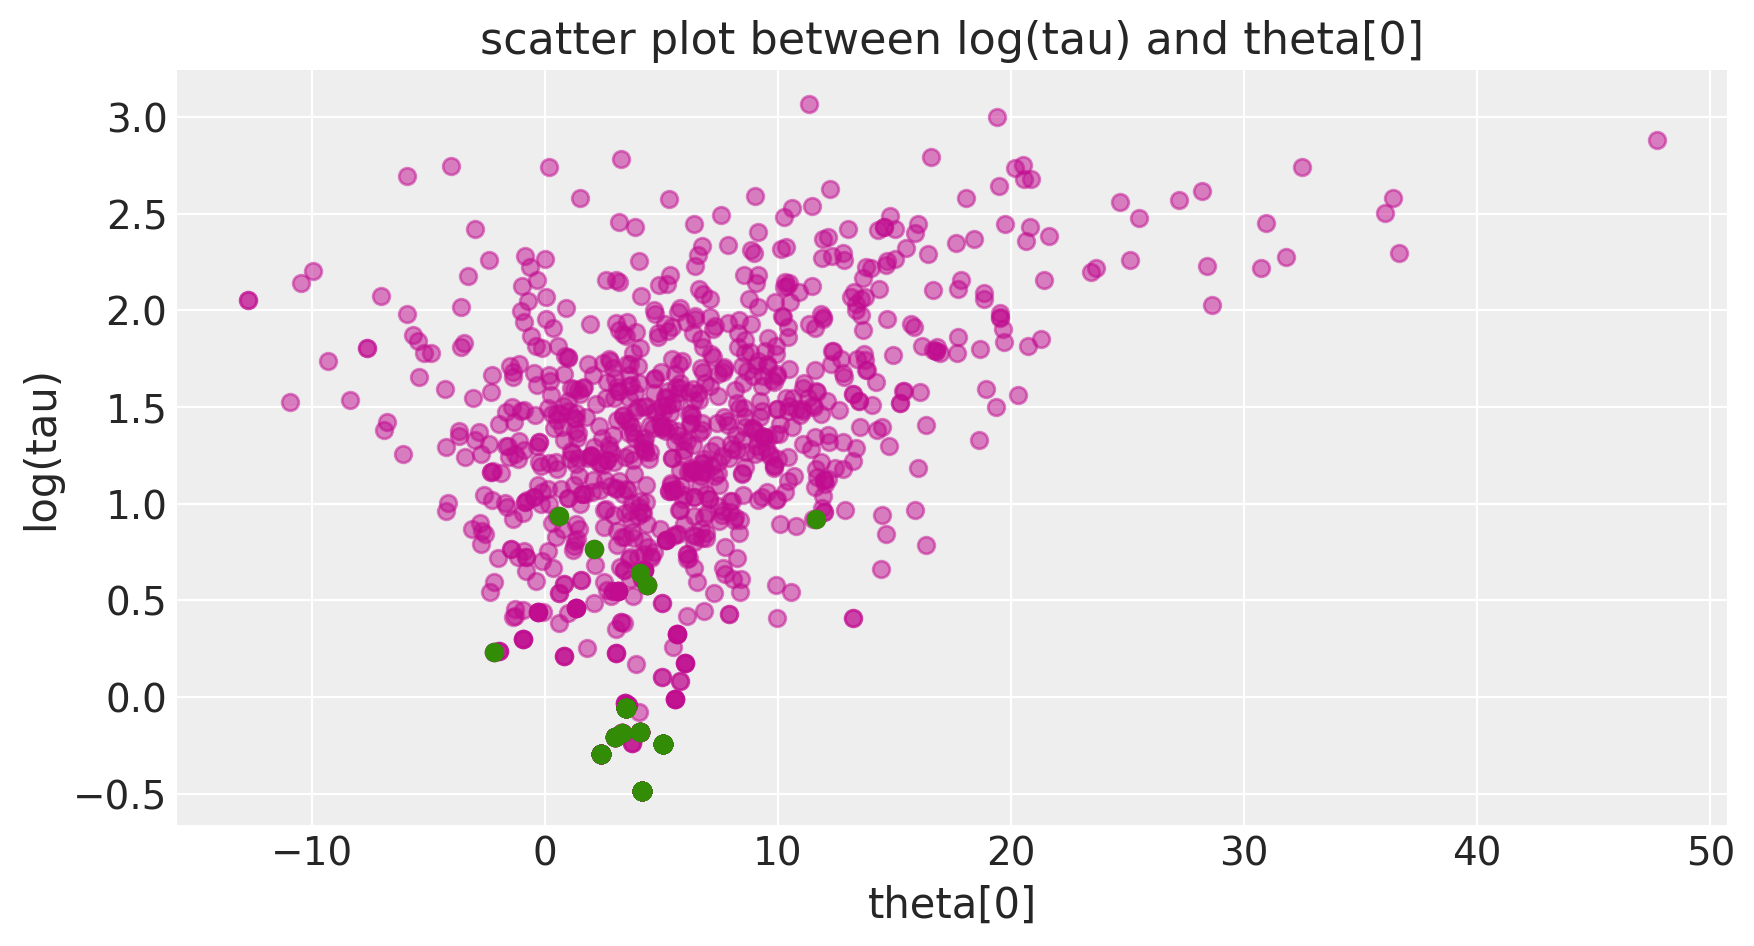

In [10]:
def pairplot_divergence(trace, ax=None, divergence=True, color='C3', divergence_color='C2'):
    theta = trace.get_values(varname='theta', combine=True)[:, 0]
    logtau = trace.get_values(varname='tau_log__', combine=True)
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(theta, logtau, 'o', color=color, alpha=.5)
    if divergence:
        divergent = trace['diverging']
        ax.plot(theta[divergent], logtau[divergent], 'o', color=divergence_color)
    ax.set_xlabel('theta[0]')
    ax.set_ylabel('log(tau)')
    ax.set_title('scatter plot between log(tau) and theta[0]');
    return ax

pairplot_divergence(short_trace);

It is important to point out that the pathological samples from the trace are not necessarily concentrated at the funnel: when a divergence is encountered, the subtree being constructed is rejected and the transition samples uniformly from the existing discrete trajectory. Consequently, divergent samples will not be located exactly in the region of high curvature.

In `pymc3`, we recently implemented a warning system that also saves the information of _where_ the divergence occurs, and hence you can visualize them directly. To be more precise, what we include as the divergence point in the warning is the point where that problematic leapfrog step started. Some could also be because the divergence happens in one of the leapfrog step (which strictly speaking is not a point). But nonetheless, visualizing these should give a closer proximate where the funnel is.

Notice that only the first 100 divergences are stored, so that we don't eat all memory.

In [11]:
divergent_point = defaultdict(list)

chain_warn = short_trace.report._chain_warnings
for i in range(len(chain_warn)):
    for warning_ in chain_warn[i]:
        if warning_.step is not None and warning_.extra is not None:
            for RV in Centered_eight.free_RVs:
                para_name = RV.name
                divergent_point[para_name].append(warning_.extra[para_name])

for RV in Centered_eight.free_RVs:
    para_name = RV.name
    divergent_point[para_name] = np.asarray(divergent_point[para_name])
ii = 5

tau_log_d = divergent_point['tau_log__']
theta0_d = divergent_point['theta'][:, ii]
Ndiv_recorded = len(tau_log_d)

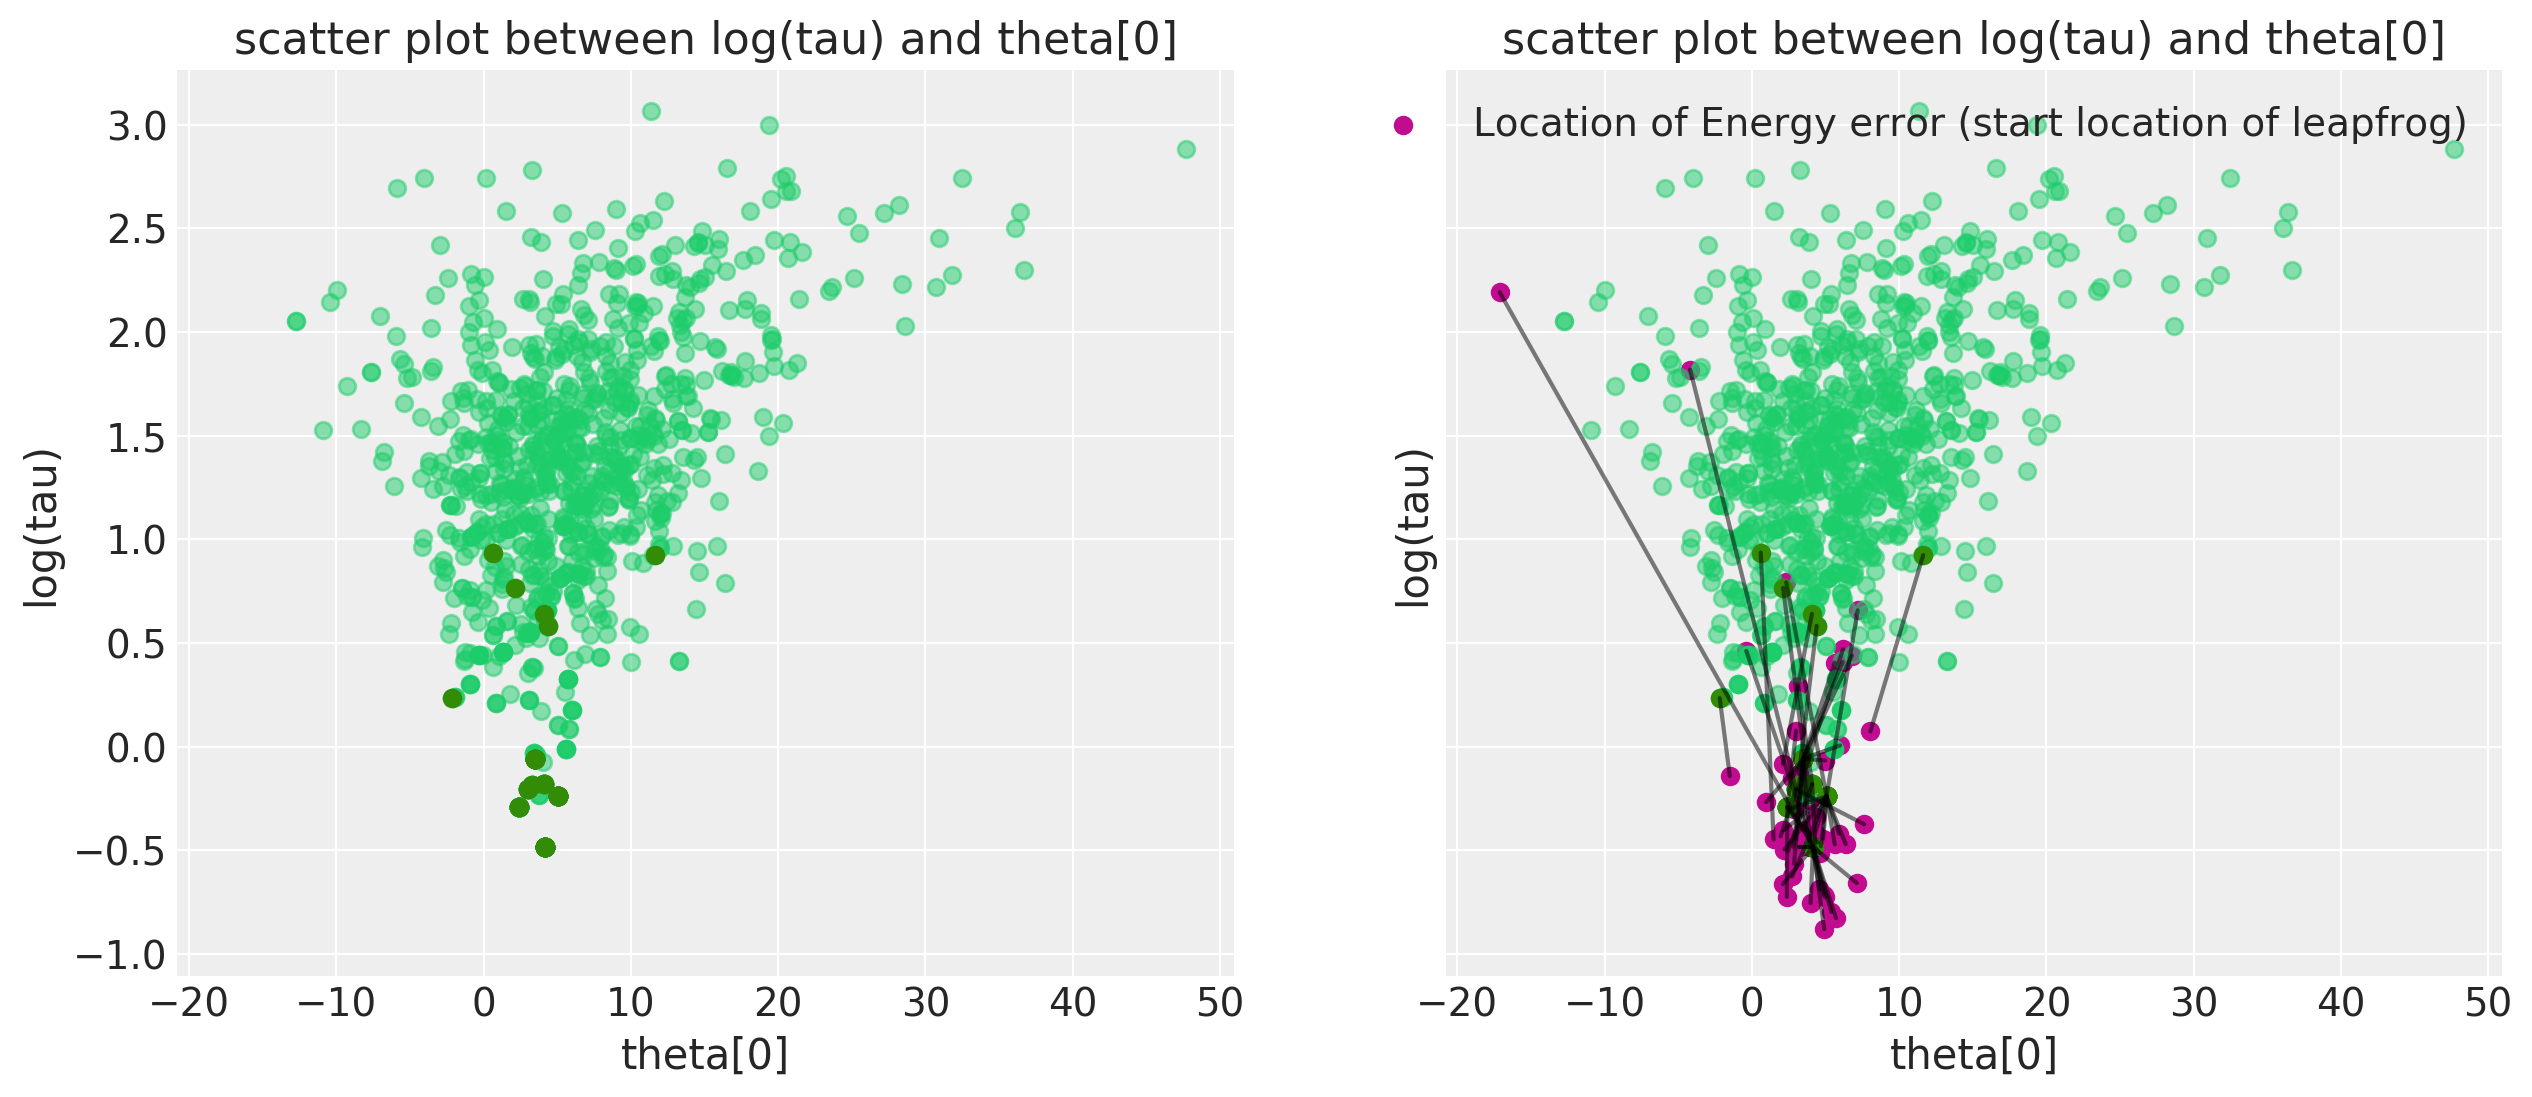

In [12]:
_, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)

pairplot_divergence(short_trace, ax=ax[0], color='C7', divergence_color='C2')

plt.title('scatter plot between log(tau) and theta[0]')

pairplot_divergence(short_trace, ax=ax[1], color='C7', divergence_color='C2')

theta_trace = short_trace['theta']
theta0 = theta_trace[:, 0]

ax[1].plot([theta0[divergent == 1][:Ndiv_recorded], theta0_d],
           [logtau[divergent == 1][:Ndiv_recorded], tau_log_d],
           'k-', alpha=.5)

ax[1].scatter(theta0_d, tau_log_d, 
              color='C3', 
              label='Location of Energy error (start location of leapfrog)')

plt.title('scatter plot between log(tau) and theta[0]')
plt.legend();

There are many other ways to explore and visualize the pathological region in the parameter space. For example, we can reproduce Figure 5b in [Visualization in Bayesian workflow](https://arxiv.org/pdf/1709.01449.pdf)

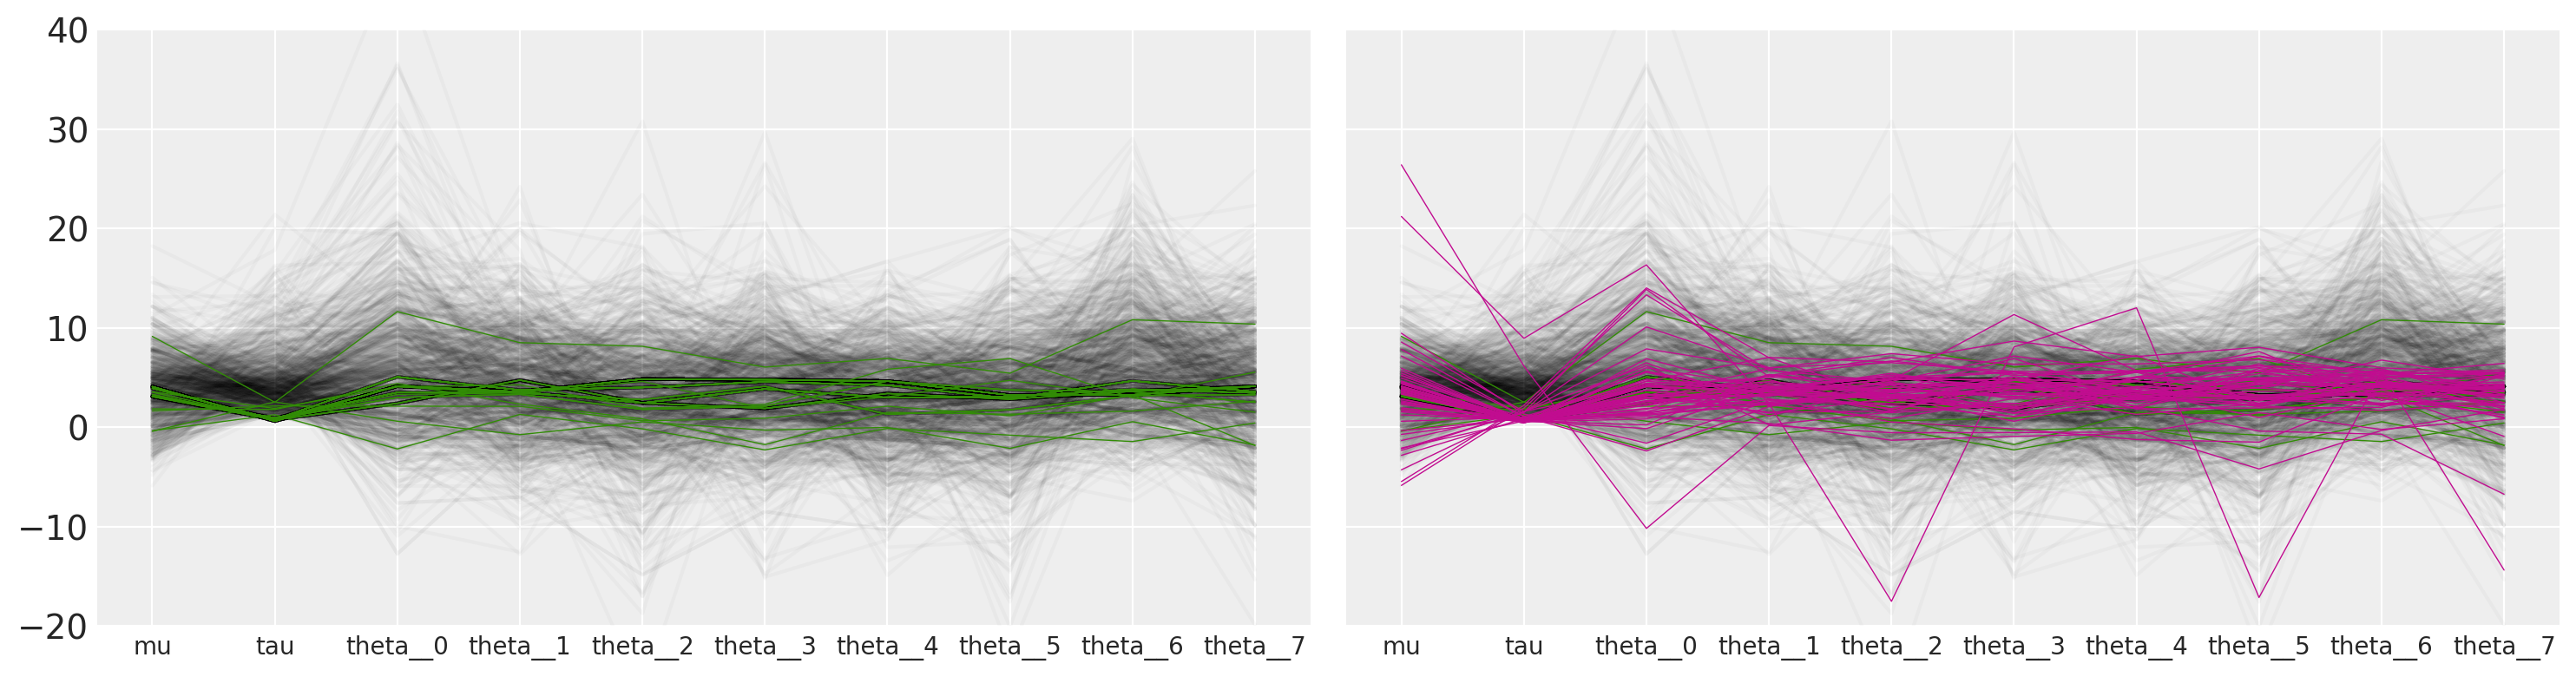

In [13]:
tracedf = pm.trace_to_dataframe(short_trace)
plotorder = ['mu', 'tau', 'theta__0', 'theta__1', 'theta__2', 'theta__3', 'theta__4',
             'theta__5', 'theta__6', 'theta__7']
tracedf = tracedf[plotorder]

_, ax = plt.subplots(1, 2, figsize=(15, 4), sharex=True, sharey=True)
ax[0].plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
ax[0].plot(tracedf.values[divergent == 1].T, color='C2', lw=.5)
ax[0].xaxis.set_tick_params(labelsize=10)

ax[1].plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
ax[1].plot(tracedf.values[divergent == 1].T, color='C2', lw=.5)
ax[1].xaxis.set_tick_params(labelsize=10)
divsp = np.hstack([divergent_point['mu'][:,None],
                   np.exp(divergent_point['tau_log__'])[:,None],
                   divergent_point['theta']])
ax[1].plot(divsp.T, 'C3', lw=.5)
plt.ylim([-20,40])
plt.xticks(range(10), plotorder)
#ax[1].xaxis.set_tick_params(range(10), plotorder, labelsize=10)
plt.tight_layout();

In [14]:
# A small wrapper function for displaying the MCMC sampler diagnostics as above
def report_trace(trace):
    # plot the trace of log(tau)
    pm.traceplot({"log(tau)": trace.get_values(varname='tau_log__', combine=False)});
    
    # plot the estimate for the mean of log(τ) cumulating mean
    logtau = np.log(trace['tau'])
    mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
    plt.figure(figsize=(15, 4))
    plt.axhline(0.7657852, lw=2.5, color='gray')
    plt.plot(mlogtau, lw=2.5)
    plt.ylim(0, 2)
    plt.xlabel('Iteration')
    plt.ylabel('MCMC mean of log(tau)')
    plt.title('MCMC estimation of log(tau)')
    plt.show()
    
    # display the total number and percentage of divergent
    divergent = trace['diverging']
    print('Number of Divergent %d' % divergent.nonzero()[0].size)
    divperc = divergent.nonzero()[0].size / len(trace) * 100
    print('Percentage of Divergent %.1f' % divperc)
    
    # scatter plot between log(tau) and theta[0]
    # for the identifcation of the problematic neighborhoods in parameter space
    pairplot_divergence(trace);

### A Safer, Longer Markov Chain  

Given the potential insensitivity of split $\hat{R}$ on single short chains, the `Stan` team recommend always running multiple chains as long as possible to have the best chance to observe any obstructions to geometric ergodicity. Because it is not always possible to run long chains for complex models, however, divergences are an incredibly powerful diagnostic for biased MCMC estimation.  

In [15]:
with Centered_eight:
    longer_trace = pm.sample(4000, chains=2, tune=1000, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 64 seconds.
There were 224 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5963528759316614, but should be close to 0.8. Try to increase the number of tuning steps.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6680313894320931, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


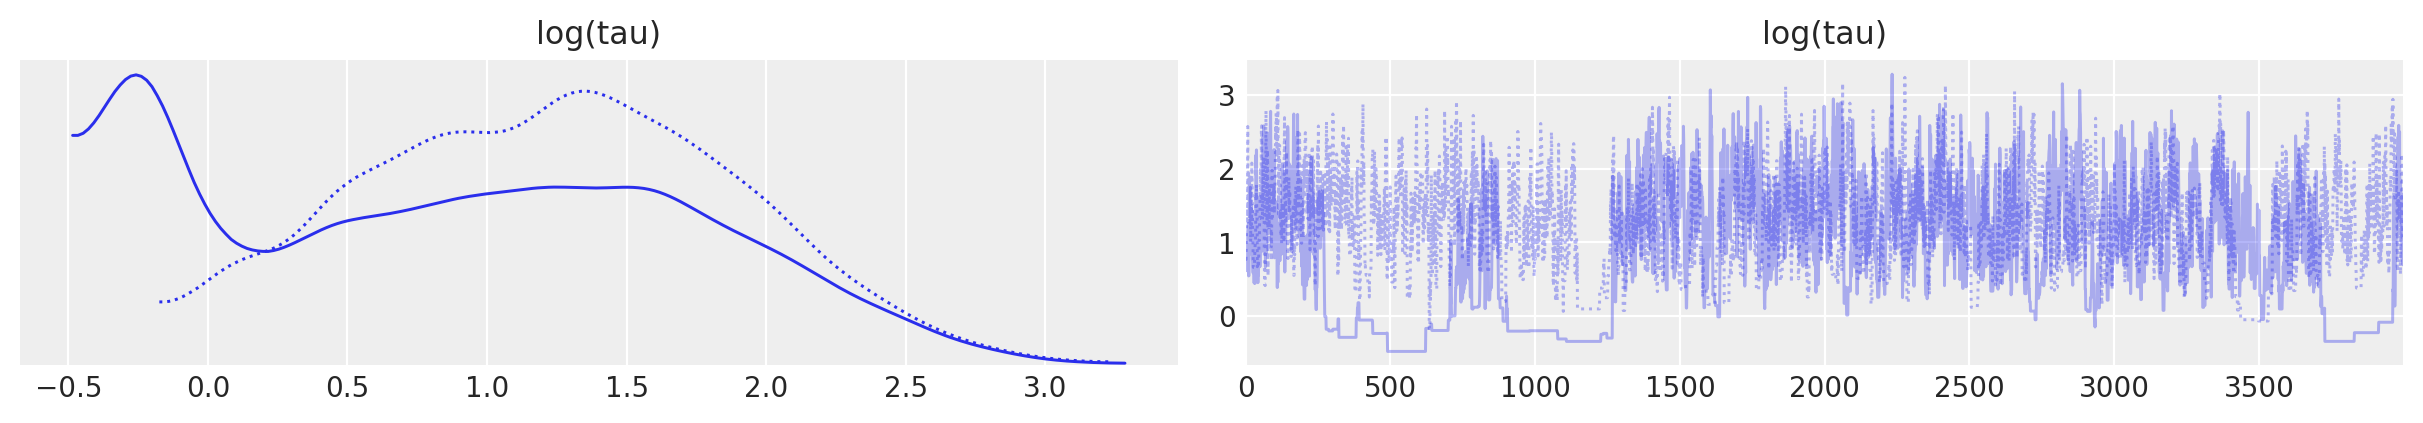

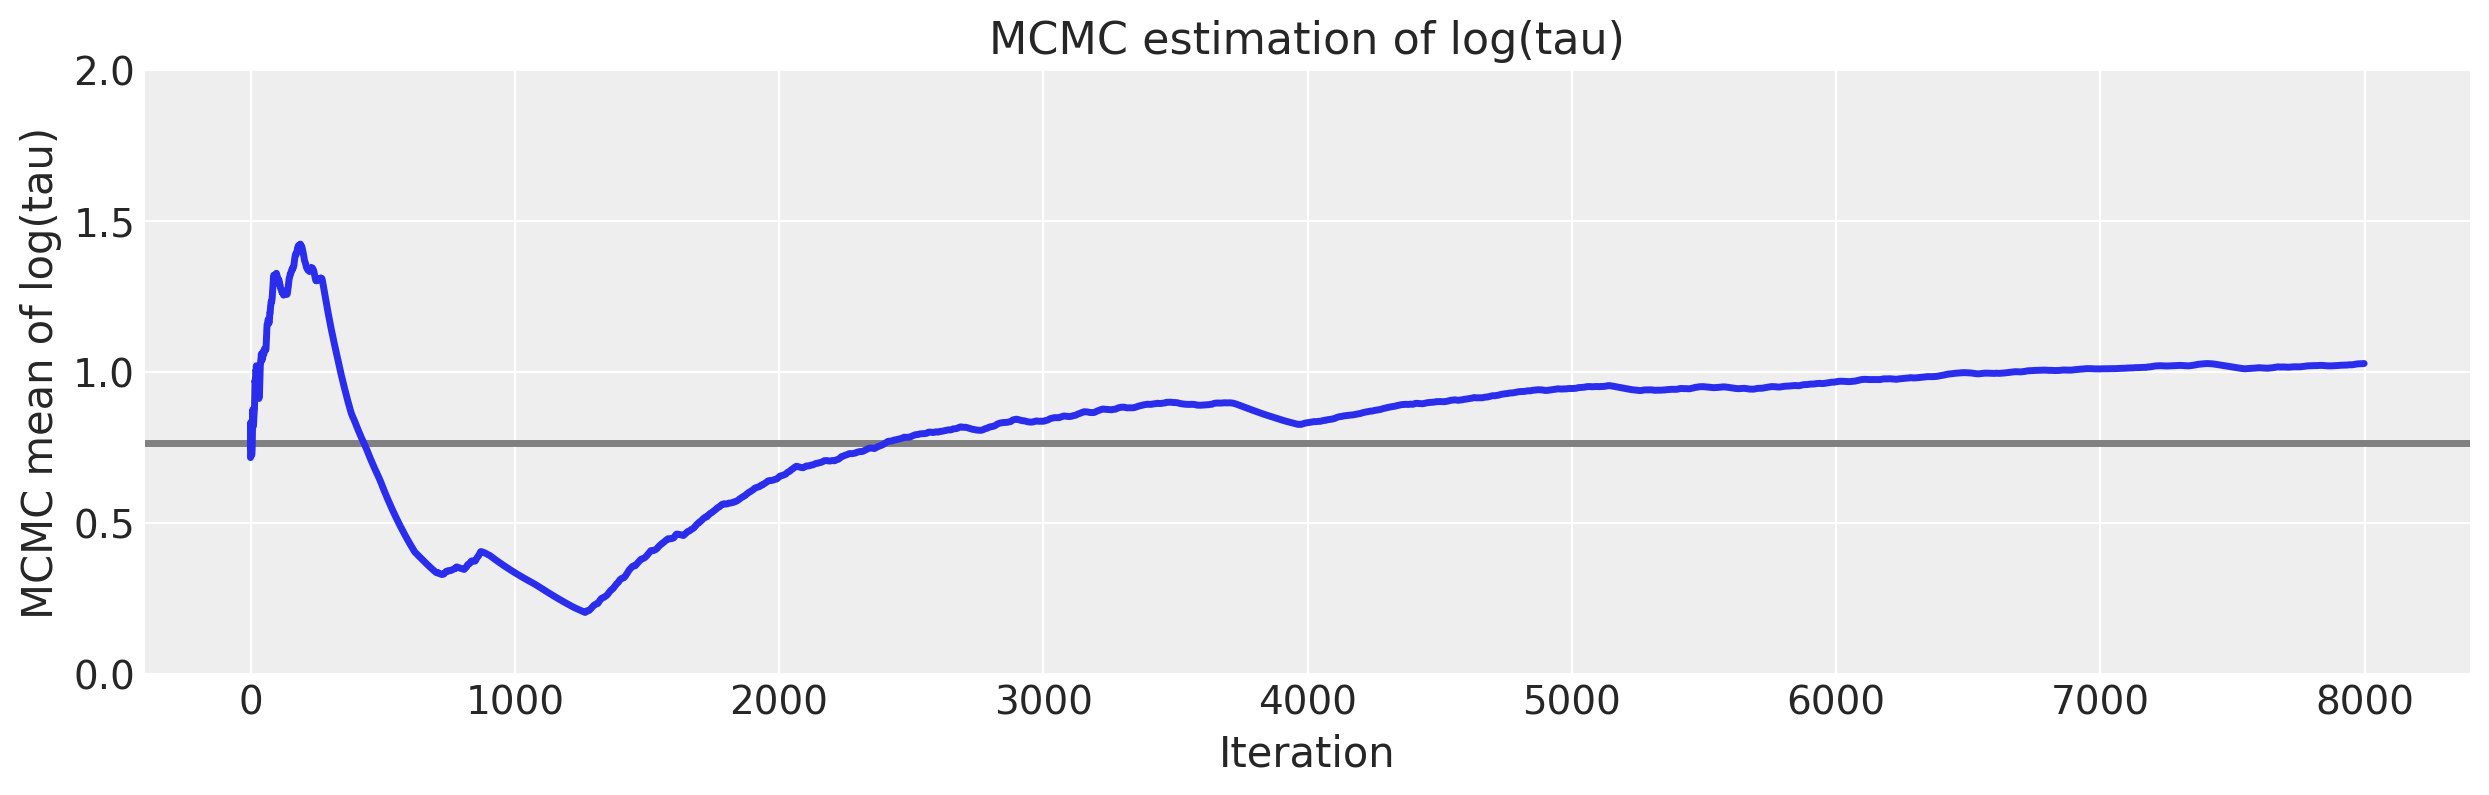

Number of Divergent 289
Percentage of Divergent 7.2


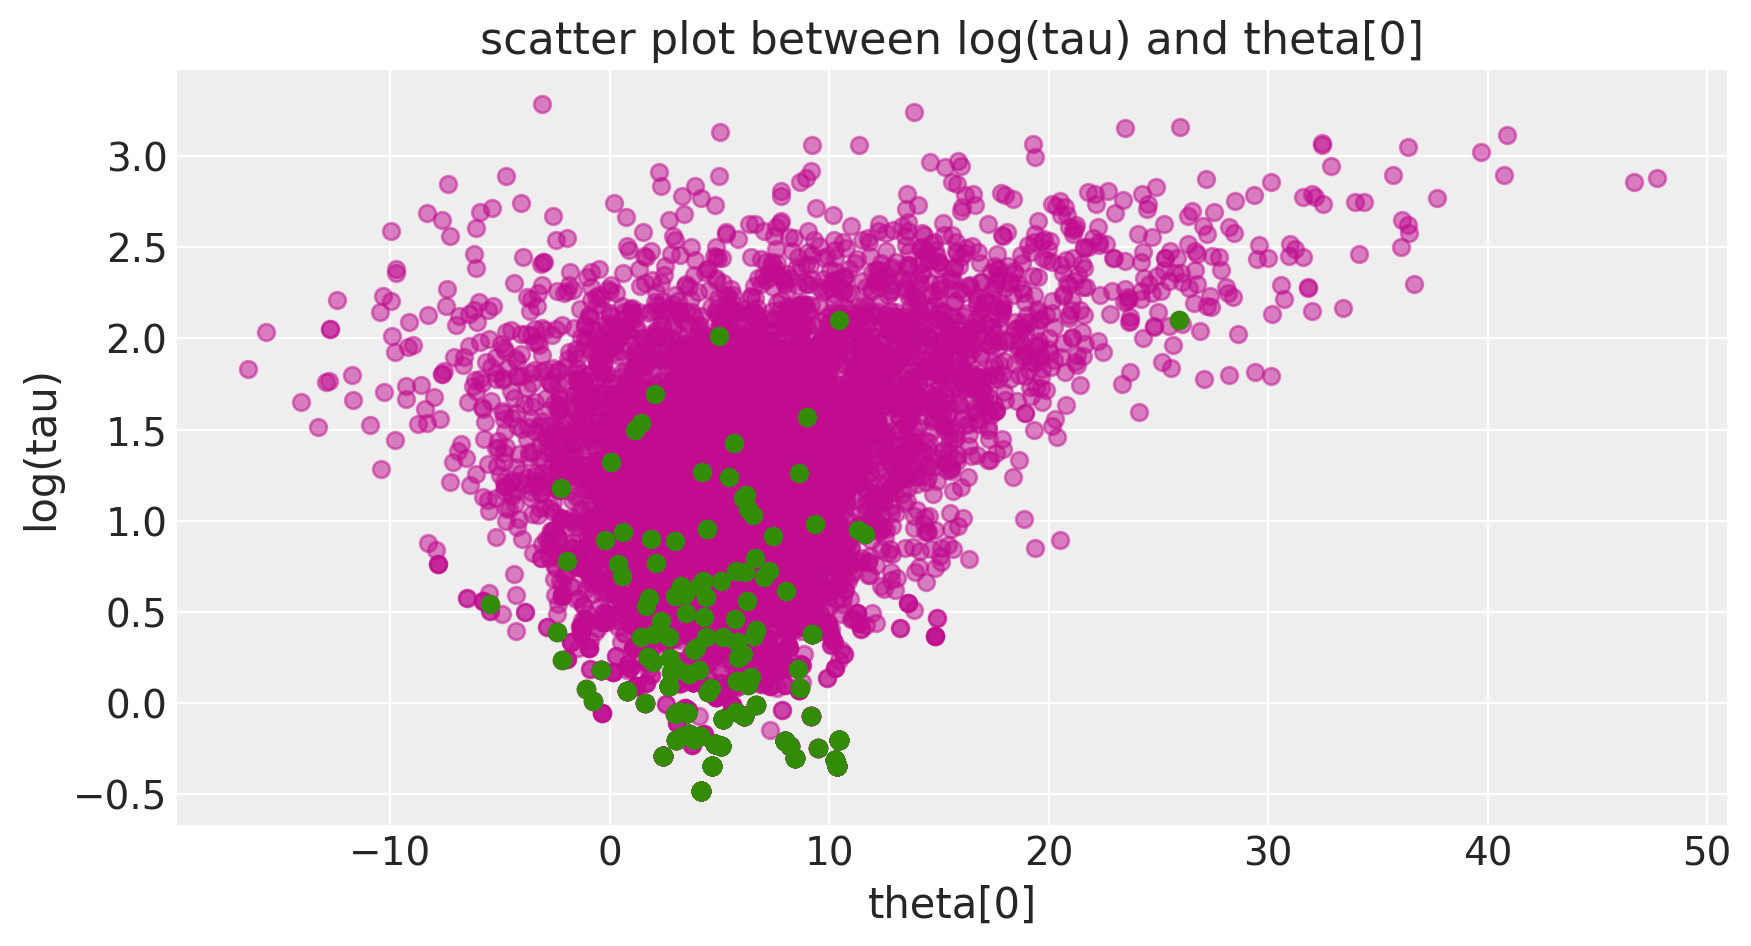

In [16]:
report_trace(longer_trace)

In [17]:
with Centered_eight:
    long_trace_summary = pm.summary(longer_trace).round(2)
long_trace_summary

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu        4.43  3.25   -1.74    10.14       0.26     0.22     161.0   114.0   
theta[0]  6.36  5.74   -3.61    17.74       0.21     0.15     736.0   736.0   
theta[1]  4.95  4.68   -4.49    13.14       0.23     0.16     406.0   406.0   
theta[2]  3.89  5.39   -6.68    13.67       0.28     0.20     384.0   384.0   
theta[3]  4.69  4.78   -4.86    13.49       0.20     0.14     568.0   568.0   
theta[4]  3.66  4.61   -6.23    11.37       0.26     0.18     320.0   320.0   
theta[5]  3.98  4.82   -4.99    13.30       0.26     0.19     336.0   336.0   
theta[6]  6.43  5.04   -2.99    16.11       0.19     0.13     723.0   723.0   
theta[7]  4.88  5.26   -5.07    15.11       0.20     0.14     710.0   710.0   
tau       3.79  3.07    0.62     9.31       0.32     0.22      95.0    95.0   

          ess_bulk  ess_tail  r_hat  
mu           166.0    1722.0   1.01  
theta[0]     550.0    1727.0   1.00  
theta[1]     351.0    2921.0   1.01  
theta[2]     280.0    2432.0   1.01  
theta[3]     409.0    2919.0   1.00  
theta[4]     276.0    2951.0   1.01  
theta[5]     281.0    2606.0   1.01  
theta[6]     602.0    1851.0   1.00  
theta[7]     546.0    2651.0   1.01  
tau           31.0      61.0   1.06

In [18]:
short = short_trace_summary.copy()
short["ess/it"] = (short['ess_mean'] / len(short_trace)).round(2)
short.columns = pd.MultiIndex.from_product([['short'], list(short.columns)])
long = long_trace_summary.copy()
long["ess/it"] = (long['ess_mean'] / len(longer_trace)).round(2)
long.columns = pd.MultiIndex.from_product([['long'], list(long.columns)])
pd.set_option('display.max_columns', None)
compare_frame = pd.concat([short, long], axis=1)
display(compare_frame)
display(compare_frame[[('short', 'r_hat'), ('long', 'r_hat'), ('short', 'ess/it'), ('long', 'ess/it')]])
#display(compare_frame[[['short', 'ess/it'], ['long', 'ess/it']]])

short                                                         \
          mean    sd hdi_3% hdi_97% mcse_mean mcse_sd ess_mean ess_sd   
mu        3.79  2.98  -2.84    9.07      0.19    0.14    242.0  228.0   
theta[0]  5.61  5.86  -4.26   16.79      0.37    0.44    247.0   90.0   
theta[1]  4.14  4.43  -4.27   13.06      0.24    0.42    327.0   56.0   
theta[2]  3.21  5.04  -6.39   13.57      0.26    0.24    371.0  219.0   
theta[3]  3.93  4.65  -5.52   12.76      0.22    0.20    451.0  275.0   
theta[4]  3.14  4.21  -5.88   10.77      0.20    0.20    422.0  226.0   
theta[5]  3.13  4.74  -7.03   11.94      0.23    0.37    424.0   81.0   
theta[6]  5.81  5.05  -2.35   16.51      0.92    0.72     30.0   26.0   
theta[7]  4.08  4.73  -4.63   14.50      0.22    0.43    481.0   60.0   
tau       3.67  3.10   0.62    9.55      1.26    0.94      6.0    6.0   

                                         long                                 \
         ess_bulk ess_tail r_hat ess/it  mean    sd hdi_3% hdi_97% mcse_mean   
mu          221.0    402.0  1.27   0.40  4.43  3.25  -1.74   10.14      0.26   
theta[0]    220.0    198.0  1.32   0.41  6.36  5.74  -3.61   17.74      0.21   
theta[1]    293.0    506.0  1.42   0.55  4.95  4.68  -4.49   13.14      0.23   
theta[2]    284.0    371.0  1.16   0.62  3.89  5.39  -6.68   13.67      0.28   
theta[3]    345.0    499.0  1.19   0.75  4.69  4.78  -4.86   13.49      0.20   
theta[4]    362.0    380.0  1.23   0.70  3.66  4.61  -6.23   11.37      0.26   
theta[5]    378.0    368.0  1.40   0.71  3.98  4.82  -4.99   13.30      0.26   
theta[6]     79.0    313.0  1.25   0.05  6.43  5.04  -2.99   16.11      0.19   
theta[7]    433.0    580.0  1.47   0.80  4.88  5.26  -5.07   15.11      0.20   
tau           3.0      6.0  1.61   0.01  3.79  3.07   0.62    9.31      0.32   

                                                                 
         mcse_sd ess_mean ess_sd ess_bulk ess_tail r_hat ess/it  
mu          0.22    161.0  114.0    166.0   1722.0  1.01   0.04  
theta[0]    0.15    736.0  736.0    550.0   1727.0  1.00   0.18  
theta[1]    0.16    406.0  406.0    351.0   2921.0  1.01   0.10  
theta[2]    0.20    384.0  384.0    280.0   2432.0  1.01   0.10  
theta[3]    0.14    568.0  568.0    409.0   2919.0  1.00   0.14  
theta[4]    0.18    320.0  320.0    276.0   2951.0  1.01   0.08  
theta[5]    0.19    336.0  336.0    281.0   2606.0  1.01   0.08  
theta[6]    0.13    723.0  723.0    602.0   1851.0  1.00   0.18  
theta[7]    0.14    710.0  710.0    546.0   2651.0  1.01   0.18  
tau         0.22     95.0   95.0     31.0     61.0  1.06   0.02

short  long  short   long
         r_hat r_hat ess/it ess/it
mu        1.27  1.01   0.40   0.04
theta[0]  1.32  1.00   0.41   0.18
theta[1]  1.42  1.01   0.55   0.10
theta[2]  1.16  1.01   0.62   0.10
theta[3]  1.19  1.00   0.75   0.14
theta[4]  1.23  1.01   0.70   0.08
theta[5]  1.40  1.01   0.71   0.08
theta[6]  1.25  1.00   0.05   0.18
theta[7]  1.47  1.01   0.80   0.18
tau       1.61  1.06   0.01   0.02

Similar to the result in `Stan`,  $\hat{R}$ does not indicate any serious issues. However, the effective sample size per iteration has drastically fallen, indicating that we are exploring less efficiently the longer we run. This odd behavior is a clear sign that something problematic is afoot. As shown in the trace plot, the chain occasionally "sticks" as it approaches small values of $\tau$, exactly where we saw the divergences concentrating. This is a clear indication of the underlying pathologies. These sticky intervals induce severe oscillations in the MCMC estimators early on, until they seem to finally settle into biased values.   

In fact the sticky intervals are the Markov chain trying to correct the biased exploration. If we ran the chain even longer then it would eventually get stuck again and drag the MCMC estimator down towards the true value. Given an infinite number of iterations this delicate balance asymptotes to the true expectation as we’d expect given the consistency guarantee of MCMC. Stopping after any finite number of iterations, however, destroys this balance and leaves us with a significant bias. 

More details can be found in Betancourt's [recent paper](https://arxiv.org/abs/1701.02434).  

## Mitigating Divergences by Adjusting PyMC3's Adaptation Routine

Divergences in Hamiltonian Monte Carlo arise when the Hamiltonian transition encounters regions of extremely large curvature, such as the opening of the hierarchical funnel. Unable to accurate resolve these regions, the transition malfunctions and flies off towards infinity. With the transitions unable to completely explore these regions of extreme curvature, we lose geometric ergodicity and our MCMC estimators become biased.

Algorithm implemented in `Stan` uses a heuristic to quickly identify these misbehaving trajectories, and hence label divergences, without having to wait for them to run all the way to infinity. This heuristic can be a bit aggressive, however, and sometimes label transitions as divergent even when we have not lost geometric ergodicity.

To resolve this potential ambiguity we can adjust the step size, $\epsilon$, of the Hamiltonian transition. The smaller the step size the more accurate the trajectory and the less likely it will be mislabeled as a divergence. In other words, if we have geometric ergodicity between the Hamiltonian transition and the target distribution then decreasing the step size will reduce and then ultimately remove the divergences entirely. If we do not have geometric ergodicity, however, then decreasing the step size will not completely remove the divergences.

Like `Stan`, the step size in `PyMC3` is tuned automatically during warm up, but we can coerce smaller step sizes by tweaking the configuration of `PyMC3`'s adaptation routine. In particular, we can increase the `target_accept` parameter from its default value of 0.8 closer to its maximum value of 1.

### Adjusting Adaptation Routine

In [19]:
with Centered_eight:
    fit_cp85 = pm.sample(5000, chains=2, tune=2000,
                         target_accept=.85)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 88 seconds.
There were 547 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4842846814954639, but should be close to 0.85. Try to increase the number of tuning steps.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.737175456745239, but should be close to 0.85. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [20]:
with Centered_eight:
    fit_cp90 = pm.sample(5000, chains=2, tune=2000,
                         target_accept=.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 132 seconds.
There were 430 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.705290719027636, but should be close to 0.9. Try to increase the number of tuning steps.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [21]:
with Centered_eight:
    fit_cp95 = pm.sample(5000, chains=2, tune=2000,
                         target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 175 seconds.
There were 219 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8819302505195916, but should be close to 0.95. Try to increase the number of tuning steps.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [22]:
with Centered_eight:
    fit_cp99 = pm.sample(5000, chains=2, tune=2000,
                         target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 626 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9693984517210503, but should be close to 0.99. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [23]:
df = pd.DataFrame([longer_trace['step_size'].mean(),
                  fit_cp85['step_size'].mean(),
                  fit_cp90['step_size'].mean(),
                  fit_cp95['step_size'].mean(),
                  fit_cp99['step_size'].mean()], columns=['Step_size'])
df['Divergent'] = pd.Series([longer_trace['diverging'].sum(),
                            fit_cp85['diverging'].sum(),
                            fit_cp90['diverging'].sum(),
                            fit_cp95['diverging'].sum(),
                            fit_cp99['diverging'].sum()])
df['delta_target'] = pd.Series(['.80', '.85', '.90', '.95', '.99'])
df

Step_size  Divergent delta_target
0   0.237721        289          .80
1   0.244083        632          .85
2   0.164192        504          .90
3   0.137629        262          .95
4   0.043080         47          .99

Here, the number of divergent transitions dropped dramatically when delta was increased to 0.99. 

This behavior also has a nice geometric intuition. The more we decrease the step size the more the Hamiltonian Markov chain can explore the neck of the funnel. Consequently, the marginal posterior distribution for $log (\tau)$ stretches further and further towards negative values with the decreasing step size. 

Since in `PyMC3` after tuning we have a smaller step size than `Stan`, the geometery is better explored.

However, the Hamiltonian transition is still not geometrically ergodic with respect to the centered implementation of the Eight Schools model. Indeed, this is expected given the observed bias.

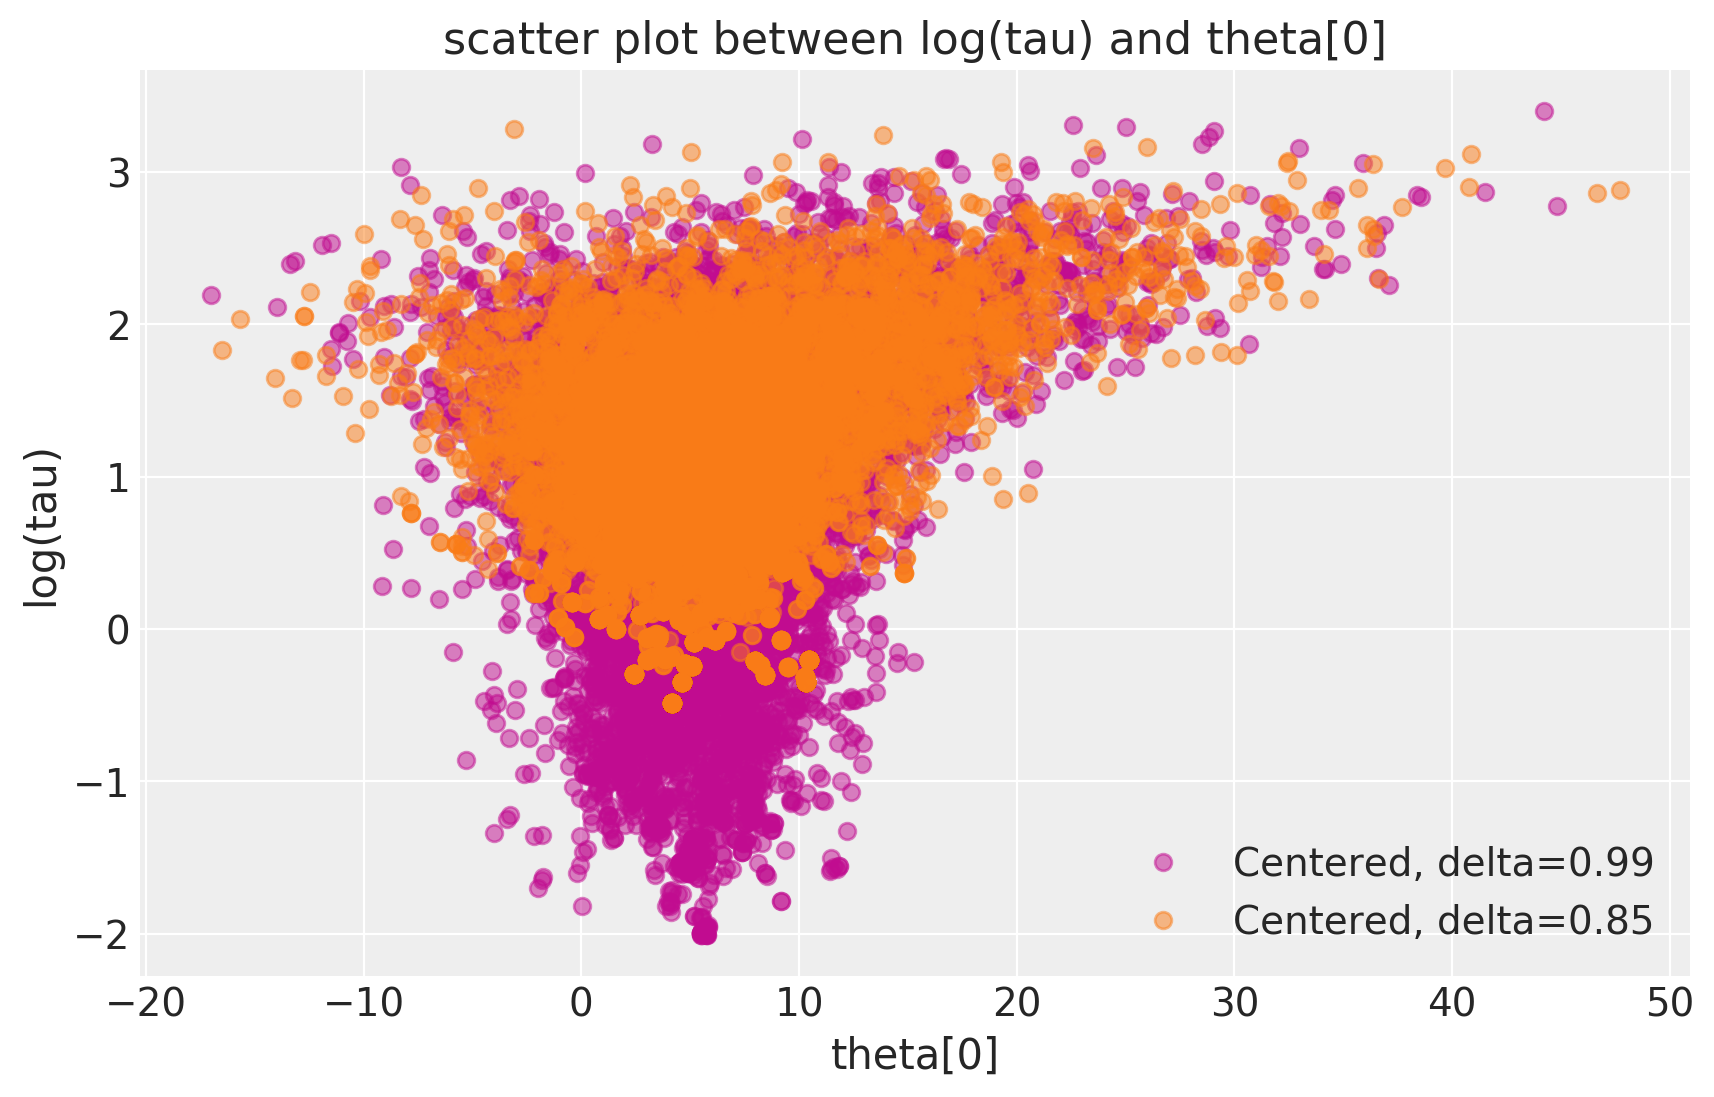

In [24]:
_, ax = plt.subplots(1, 1, figsize=(10, 6))

pairplot_divergence(fit_cp99, ax=ax, color='C3', divergence=False)

pairplot_divergence(longer_trace, ax=ax, color='C1', divergence=False)

ax.legend(['Centered, delta=0.99', 'Centered, delta=0.85']);

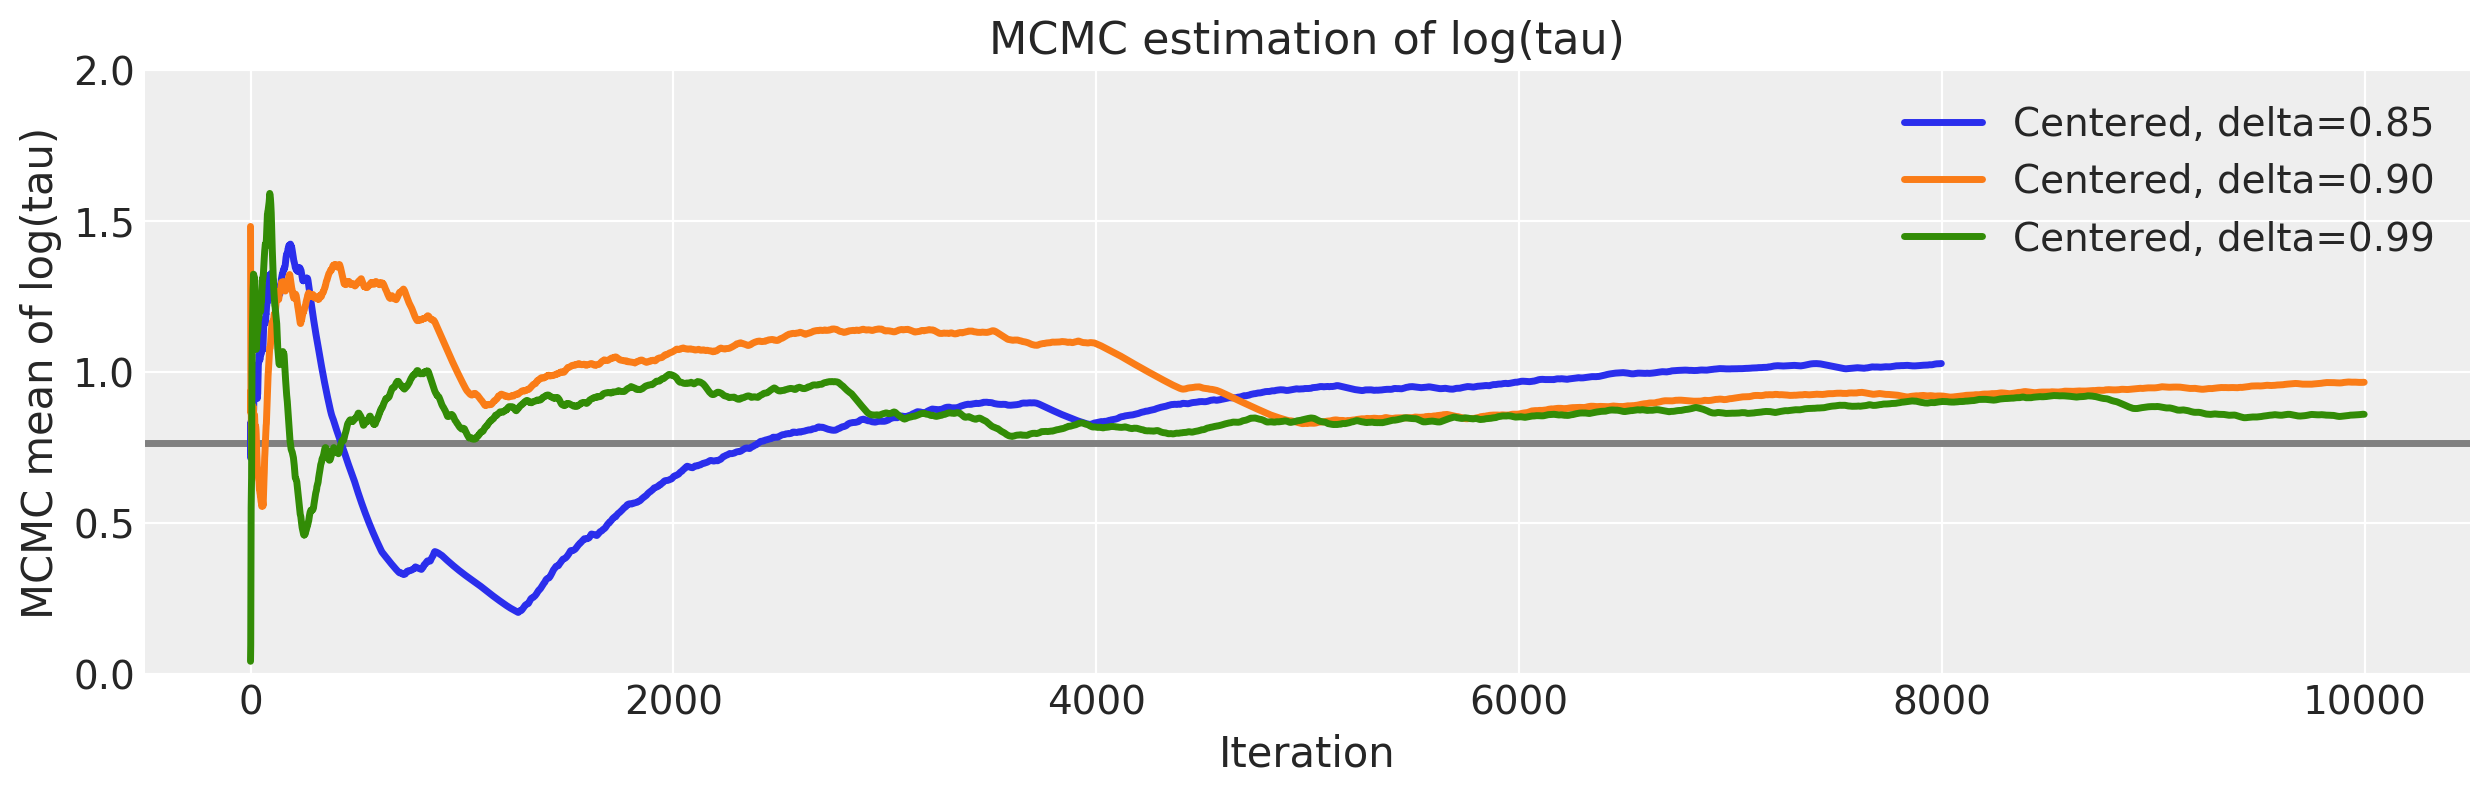

In [25]:
logtau0 = longer_trace['tau_log__']
logtau2 = np.log(fit_cp90['tau'])
logtau1 = fit_cp99['tau_log__']

plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
mlogtau0 = [np.mean(logtau0[:i]) for i in np.arange(1, len(logtau0))]
plt.plot(mlogtau0, label='Centered, delta=0.85', lw=2.5)
mlogtau2 = [np.mean(logtau2[:i]) for i in np.arange(1, len(logtau2))]
plt.plot(mlogtau2, label='Centered, delta=0.90', lw=2.5)
mlogtau1 = [np.mean(logtau1[:i]) for i in np.arange(1, len(logtau1))]
plt.plot(mlogtau1, label='Centered, delta=0.99', lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)')
plt.legend();

## A Non-Centered Eight Schools Implementation  
 
Although reducing the step size improves exploration, ultimately it only reveals the true extent the pathology in the centered implementation. Fortunately, there is another way to implement hierarchical models that does not suffer from the same pathologies.  

In a non-centered parameterization we do not try to fit the group-level parameters directly, rather we fit a latent Gaussian variable from which we can recover the group-level parameters with a scaling and a translation.  

$$\mu \sim \mathcal{N}(0, 5)$$
$$\tau \sim \text{Half-Cauchy}(0, 5)$$
$$\tilde{\theta}_{n} \sim \mathcal{N}(0, 1)$$
$$\theta_{n} = \mu + \tau \cdot \tilde{\theta}_{n}.$$

Stan model:

```C
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta_tilde[J];
}

transformed parameters {
  real theta[J];
  for (j in 1:J)
    theta[j] = mu + tau * theta_tilde[j];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta_tilde ~ normal(0, 1);
  y ~ normal(theta, sigma);
}
```

In [26]:
with pm.Model() as NonCentered_eight:
    mu = pm.Normal('mu', mu=0, sigma=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta_tilde = pm.Normal('theta_t', mu=0, sigma=1, shape=J)
    theta = pm.Deterministic('theta', mu + tau * theta_tilde)
    obs = pm.Normal('obs', mu=theta, sigma=sigma, observed=y)

In [27]:
with NonCentered_eight:
    fit_ncp80 = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                         target_accept=.80)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta_t, tau, mu]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 81 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.


In [28]:
with NonCentered_eight:
    non_centered_summary = pm.summary(fit_ncp80)
non_centered_summary['ess/it'] = (non_centered_summary['ess_mean'] / len(fit_ncp80))

non_centered_summary.round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu          4.39  3.29   -1.82    10.48       0.04     0.03    7835.0  7835.0   
theta_t[0]  0.32  0.97   -1.44     2.19       0.01     0.01    8819.0  4112.0   
theta_t[1]  0.10  0.94   -1.66     1.84       0.01     0.01   10792.0  4115.0   
theta_t[2] -0.10  0.96   -1.94     1.68       0.01     0.01    9766.0  3754.0   
theta_t[3]  0.08  0.95   -1.75     1.83       0.01     0.01   10151.0  3913.0   
theta_t[4] -0.17  0.92   -1.91     1.60       0.01     0.01    8723.0  4381.0   
theta_t[5] -0.07  0.94   -1.85     1.67       0.01     0.01   11371.0  4170.0   
theta_t[6]  0.36  0.96   -1.47     2.13       0.01     0.01    9296.0  4715.0   
theta_t[7]  0.07  0.98   -1.72     1.94       0.01     0.01   11460.0  4386.0   
tau         3.64  3.36    0.00     9.39       0.05     0.04    3978.0  2897.0   
theta[0]    6.26  5.57   -4.45    16.36       0.07     0.06    5790.0  4502.0   
theta[1]    4.93  4.55   -3.61    13.80       0.05     0.04    9620.0  7715.0   
theta[2]    3.84  5.30   -5.75    14.24       0.07     0.06    6214.0  3931.0   
theta[3]    4.86  4.85   -3.93    14.24       0.05     0.05    7976.0  5170.0   
theta[4]    3.57  4.64   -5.70    11.97       0.05     0.04    7602.0  6865.0   
theta[5]    4.02  4.90   -4.93    13.28       0.06     0.05    7198.0  5696.0   
theta[6]    6.35  4.99   -2.62    16.06       0.06     0.04    8011.0  6060.0   
theta[7]    4.92  5.33   -4.54    15.72       0.06     0.04    8007.0  6886.0   

            ess_bulk  ess_tail  r_hat  ess/it  
mu            7989.0    4425.0    1.0    1.57  
theta_t[0]    8725.0    5684.0    1.0    1.76  
theta_t[1]   10769.0    6229.0    1.0    2.16  
theta_t[2]    9775.0    5893.0    1.0    1.95  
theta_t[3]   10138.0    6101.0    1.0    2.03  
theta_t[4]    8720.0    6476.0    1.0    1.74  
theta_t[5]   11379.0    7066.0    1.0    2.27  
theta_t[6]    9316.0    6189.0    1.0    1.86  
theta_t[7]   11444.0    6889.0    1.0    2.29  
tau           4428.0    3569.0    1.0    0.80  
theta[0]      6820.0    4801.0    1.0    1.16  
theta[1]      9824.0    6967.0    1.0    1.92  
theta[2]      7419.0    5379.0    1.0    1.24  
theta[3]      8765.0    6023.0    1.0    1.60  
theta[4]      8189.0    5926.0    1.0    1.52  
theta[5]      7711.0    6105.0    1.0    1.44  
theta[6]      8798.0    5610.0    1.0    1.60  
theta[7]      8564.0    6393.0    1.0    1.60

As shown above, the effective sample size per iteration (`ess/it`) has drastically improved, and the trace plots no longer show any "stickyness". However, we do still see the rare divergence. These infrequent divergences do not seem concentrate anywhere in parameter space, which is indicative of the divergences being false positives.

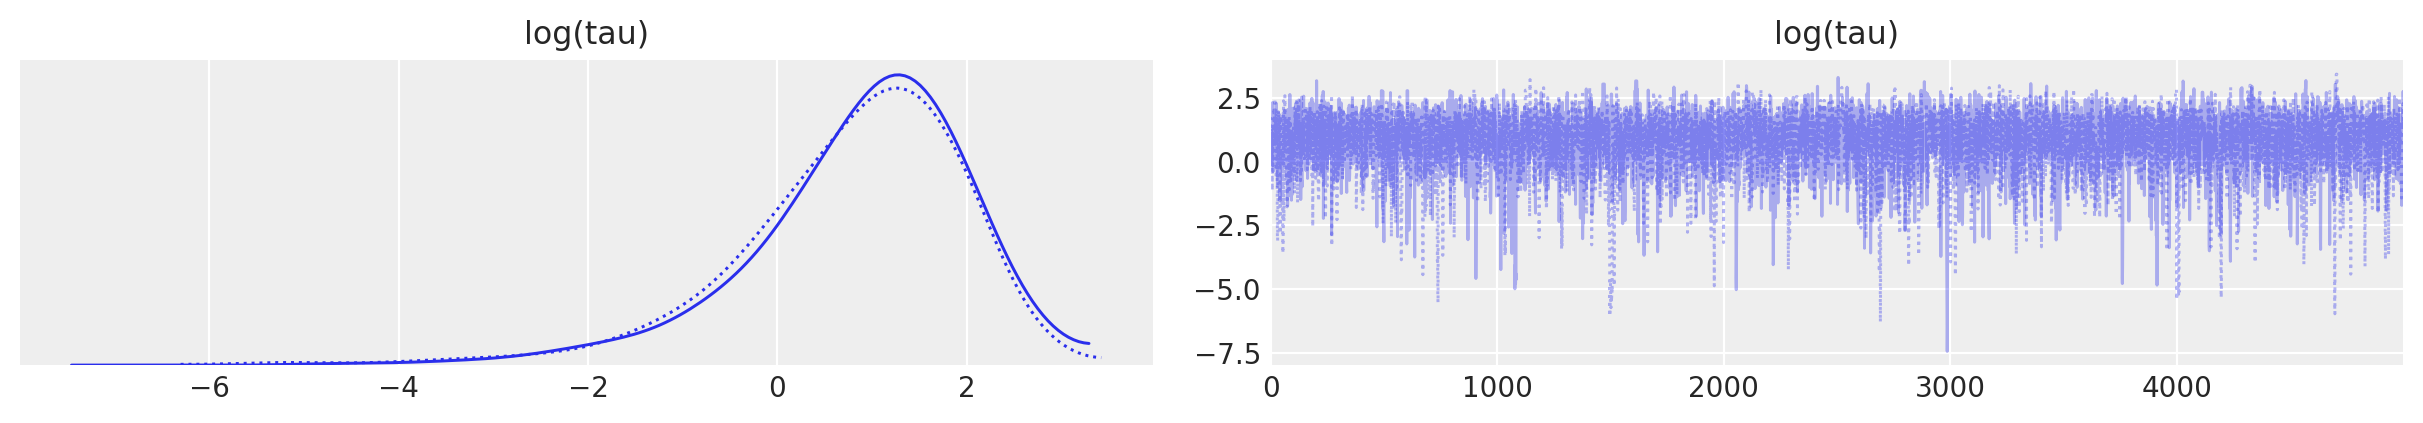

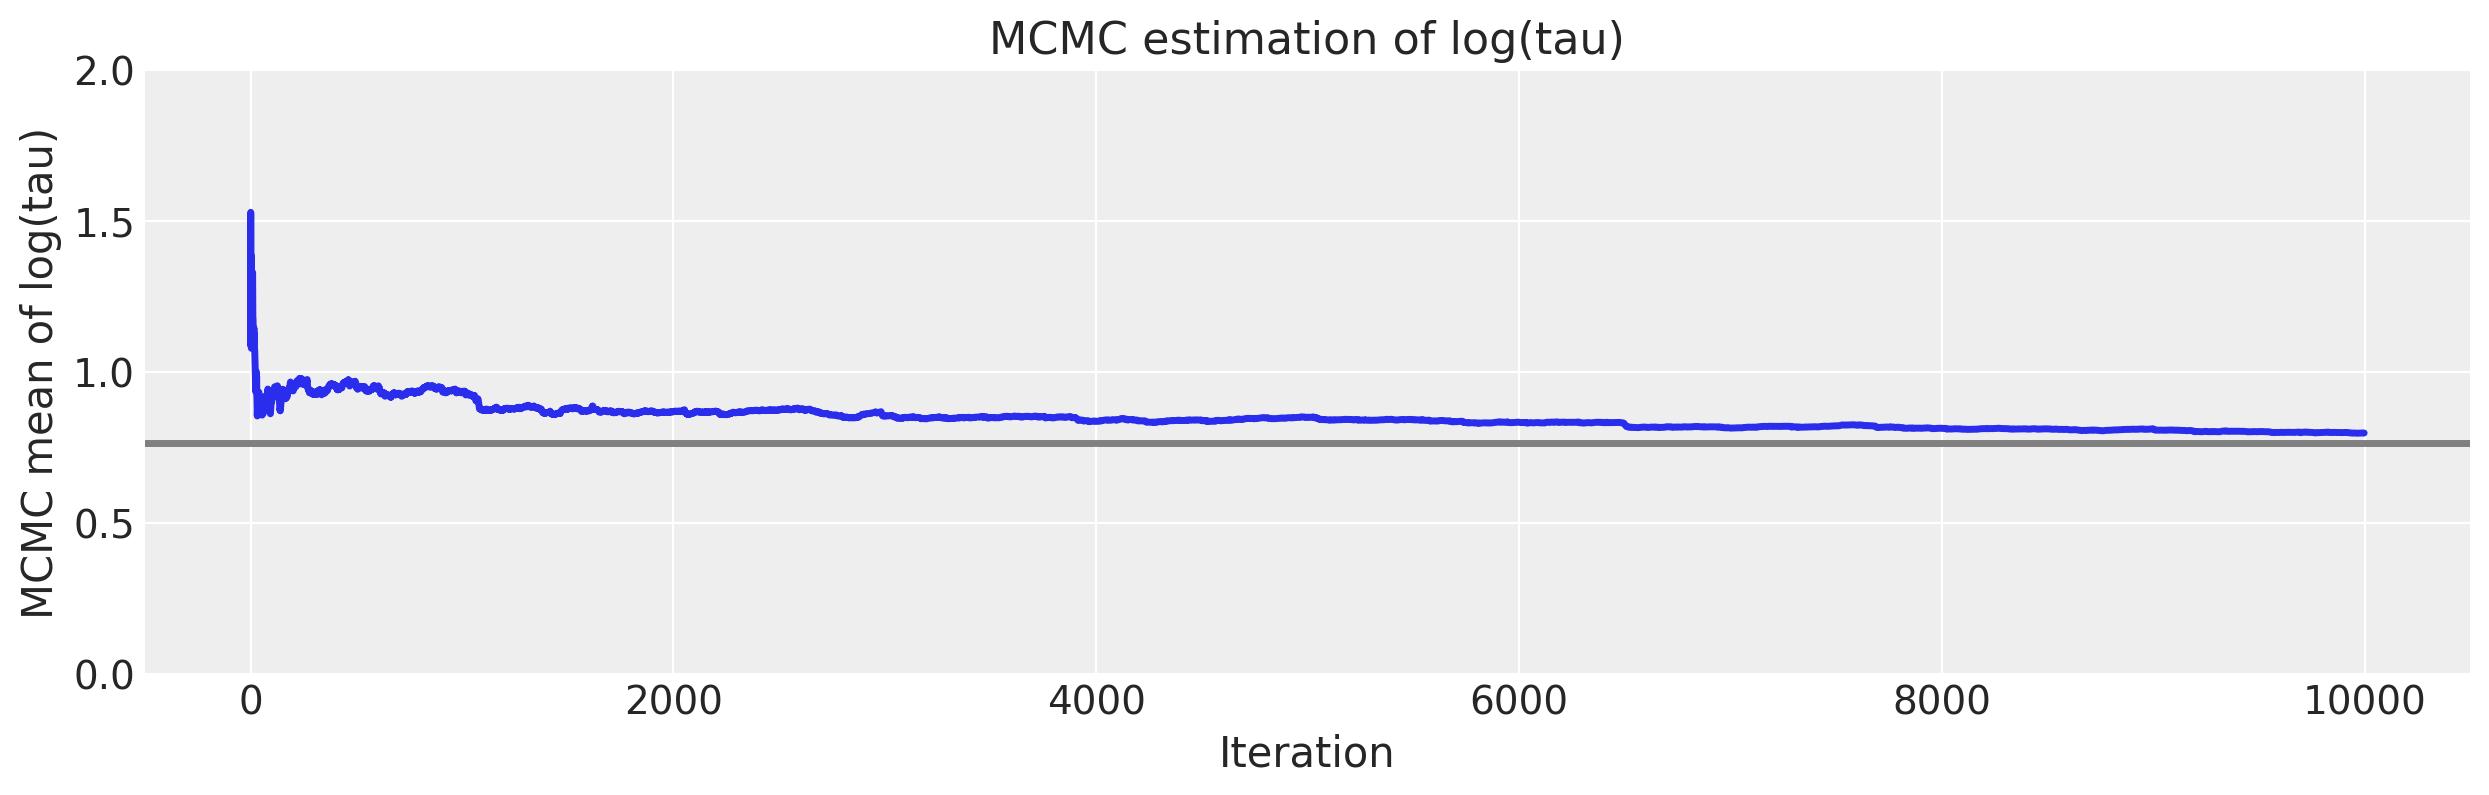

Number of Divergent 71
Percentage of Divergent 1.4


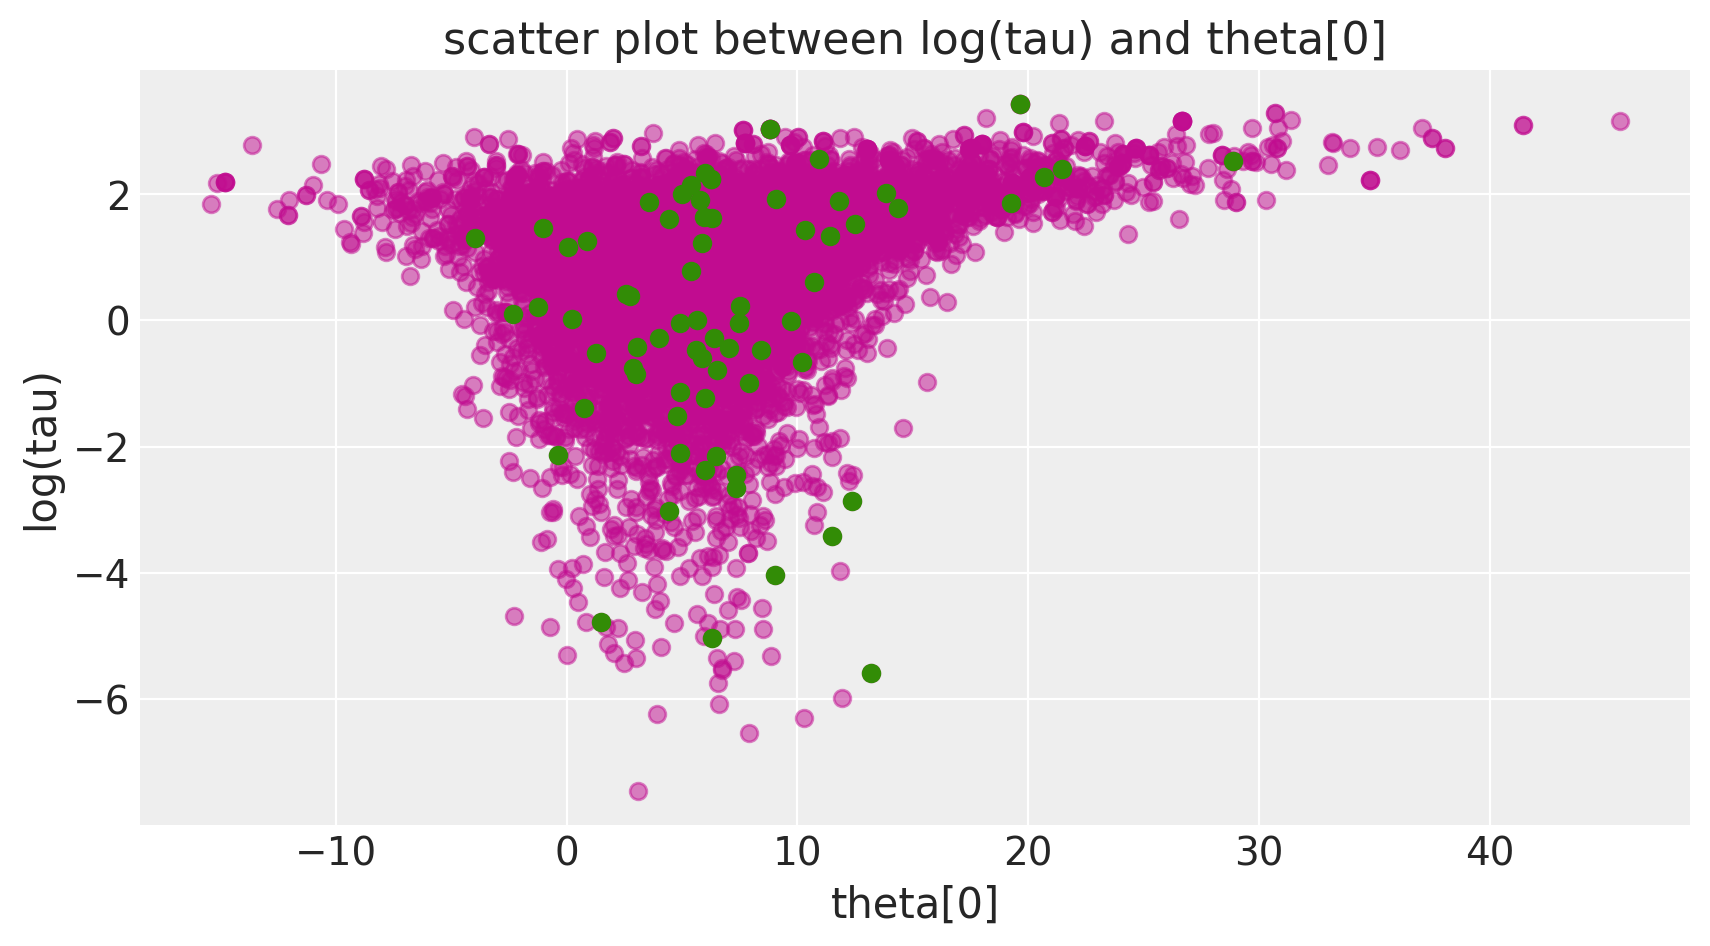

In [29]:
report_trace(fit_ncp80)

As expected of false positives, we can remove the divergences entirely by decreasing the step size,

In [30]:
with NonCentered_eight:
    fit_ncp90 = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                         target_accept=.90)
    
# display the total number and percentage of divergent
divergent = fit_ncp90['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta_t, tau, mu]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 76 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Number of Divergent 1


The more agreeable geometry of the non-centered implementation allows the Markov chain to explore deep into the neck of the funnel, capturing even the smallest values of $\tau$ that are consistent with the measurements. Consequently, MCMC estimators from the non-centered chain rapidly converge towards their true expectation values.

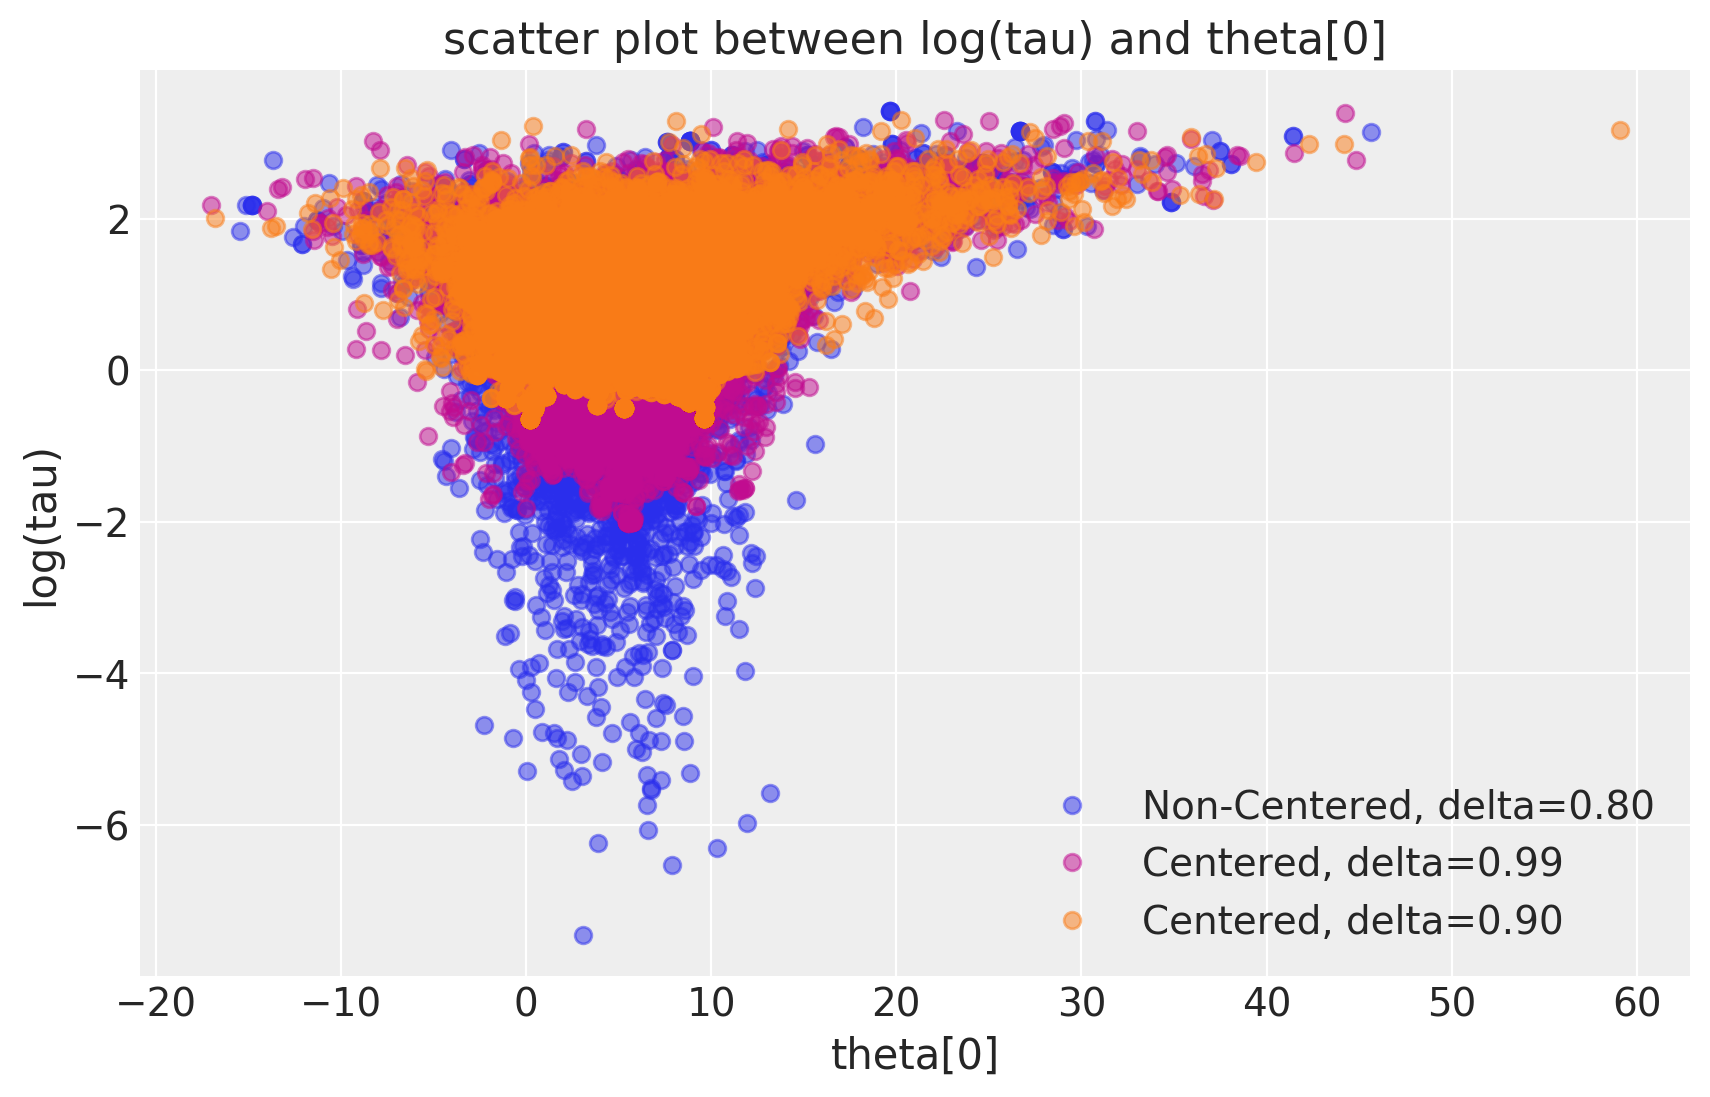

In [31]:
_, ax = plt.subplots(1, 1, figsize=(10, 6))

pairplot_divergence(fit_ncp80, ax=ax, color='C0', divergence=False)
pairplot_divergence(fit_cp99, ax=ax, color='C3', divergence=False)
pairplot_divergence(fit_cp90, ax=ax, color='C1', divergence=False)

ax.legend(['Non-Centered, delta=0.80', 'Centered, delta=0.99', 'Centered, delta=0.90']);

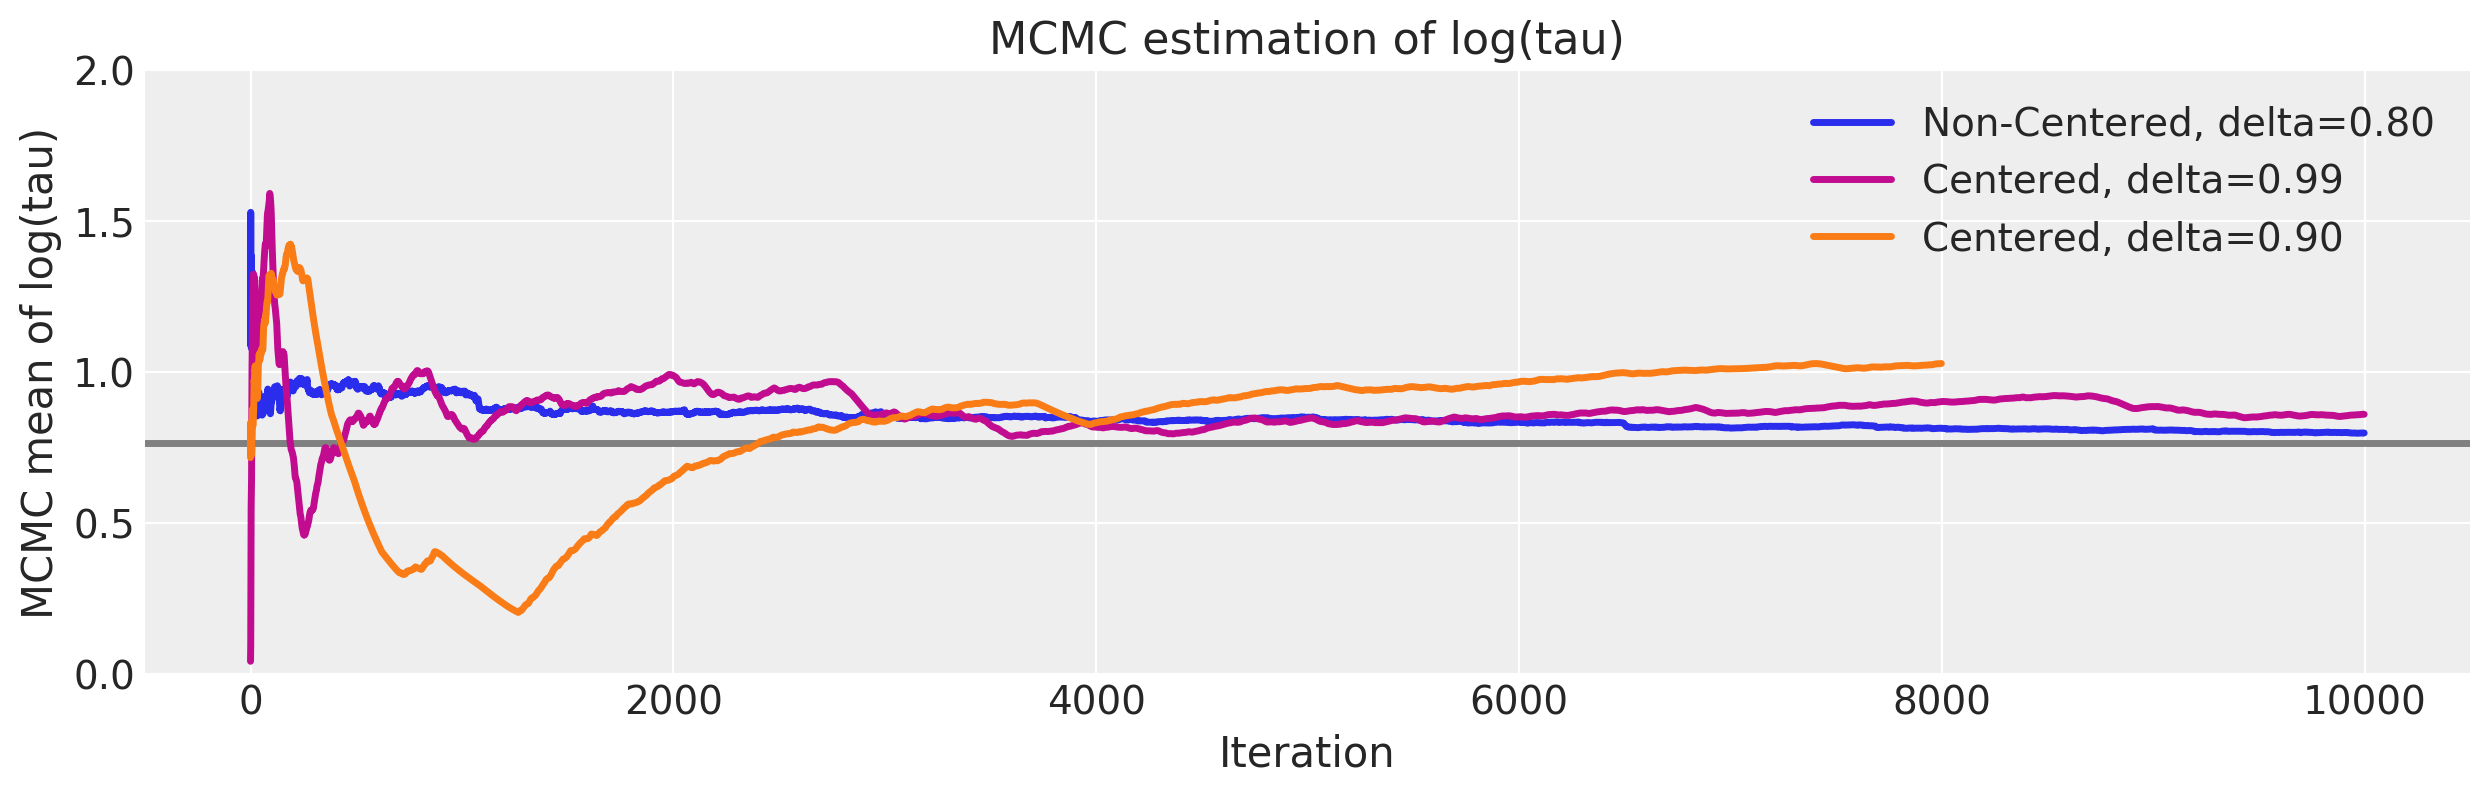

In [32]:
logtaun = fit_ncp80['tau_log__']

plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
mlogtaun = [np.mean(logtaun[:i]) for i in np.arange(1, len(logtaun))]
plt.plot(mlogtaun, color='C0', lw=2.5, label='Non-Centered, delta=0.80')

mlogtau1 = [np.mean(logtau1[:i]) for i in np.arange(1, len(logtau1))]
plt.plot(mlogtau1, color='C3', lw=2.5, label='Centered, delta=0.99')

mlogtau0 = [np.mean(logtau0[:i]) for i in np.arange(1, len(logtau0))]
plt.plot(mlogtau0, color='C1', lw=2.5, label='Centered, delta=0.90')
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)')
plt.legend();

In [33]:
%load_ext watermark
%watermark -n -u -v -iv -w

pandas 1.0.1
arviz  0.8.3
numpy  1.18.1
pymc3  3.9.1
last updated: Wed Jun 17 2020 

CPython 3.6.8
IPython 7.12.0
watermark 2.0.2
